# Data Mining Project - Bank

## Project Developed by:
- *Duarte Sardão*
- *Gabriel Ferreira*
- *Miguel Lopes*
- *Sérgio Estêvão*

## Table of Contents
1. Business Understanding
2. Data Treatment
   1. Data Loading
   2. First Merges and Date Treatment
   3. Correlations and Redundant Fields
   4. Data Extraction
   5. Merge into one Dataframe
   6. Automatic High Correlation Removal
   7. Outlier Removal
3. Classification
   1. Without Cross-Validation
   2. With Cross-Validation
      1. No Sampling
      2. Undersampling
      3. Smote
      4. K-Fold Graphs
   3. Hypertuning and Feature Selection
      1. Random Forest
      2. Logistic Regression
      3. SVM
4. Competition - Prediction
5. Plotting (Data Understanding)

## Business Understanding

The dataset is composed of a series of information that describe the activity of a Czech bank during the 90s. This includes account, client, credit cards, transaction and loan information as well as information regarding the districts where the bank's clients reside.

With this information we are expected to create a predictive model that allows the end user to determine whether or not a client is suitable to get a loan. 

In this business context, a client is granted a loan if the model predicts that the client will be able to pay it in full.

Taking into account that an unpaid loan can result in up to 100% loss, while interest is unlikely to account for 100% profit over the loan value, an unpaid loan incurrs much higher negative value than a loan that was not granted. Thus in this case, our goal should be to minimize unpaid loans and thus, as relates to data analysis: minimize the number of false positives.

## Data Treatment

In [2640]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import math
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold,KFold
from imblearn.over_sampling import SMOTE, SMOTENC
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score, PrecisionRecallDisplay
from matplotlib import pyplot
from matplotlib import colors
from sklearn.metrics import recall_score, make_scorer
from sklearn.feature_selection import SelectFromModel
from scipy.cluster.hierarchy import linkage, cophenet
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from scipy.spatial.distance import pdist
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.metrics import euclidean_distances
import statsmodels.api as sm




ModuleNotFoundError: No module named 'statsmodels'

### Data Loading

We start by loading the data into dataframes and removing information that has no relation to loans, as that data is irrelevant to the problem being targeted in this project.

In [ ]:
def loaddata(dev):
    if(dev):
        loans = pd.read_csv("./data/loan_dev.csv", sep=";",dtype=int)
        transactions = pd.read_csv("./data/trans_dev.csv", sep=";",dtype={"trans_id":int,"account_id":int,"date":int,"type":str,"operation":str,"amount":float,"balance":float,"k_symbol":str,"bank":str,"account":str})
        cards = pd.read_csv("./data/card_dev.csv", sep=";",dtype={"card_id":int,"disp_id":int,"type":str,"issued":int})
    else:
        loans = pd.read_csv("./data/loan_comp.csv", sep=";",dtype={"loan_id":int,"account_id":int,"date":int,"amount":int,"duration":int,"payments":int})
        transactions = pd.read_csv("./data/trans_comp.csv", sep=";",dtype={"trans_id":int,"account_id":int,"date":int,"type":str,"operation":str,"amount":float,"balance":float,"k_symbol":str,"bank":str,"account":str})
        cards = pd.read_csv("./data/card_comp.csv", sep=";",dtype={"card_id":int,"disp_id":int,"type":str,"issued":int})

    accounts = pd.read_csv("./data/account.csv", sep=";",dtype={"account_id":int,"district_id":int,"frequency":str,"date":int})
    clients = pd.read_csv("./data/client.csv", sep=";",dtype=int)
    dispositions = pd.read_csv("./data/disp.csv", sep=";",dtype={"disp_id":int,"client_id":int,"account_id":int,"type":str})
    districts = pd.read_csv("./data/district.csv", na_values=['?'], sep=";",dtype={"code":int, "name":str, "region":str,"no. of inhabitants":int,"no. of municipalities with inhabitants < 499":int,"no. of municipalities with inhabitants 500-1999":int,"no. of municipalities with inhabitants 2000-9999":int, "no. of municipalities with inhabitants >10000": int, "no. of cities":int, "ratio of urban inhabitants":float, "average salary":float, "unemploymant rate '95":float, "unemploymant rate '96":float, "no. of enterpreneurs per 1000 inhabitants": float, "no. of commited crimes '95":int, "no. of commited crimes '96":int})

    
    if(dev):
        print("\n==== Before Clean-up ====")
        print("Transactions: ", len(transactions))
        print("Accounts: ", len(accounts))
        print("Dispositions: ", len(dispositions))
        print("Clients: ", len(clients))
        print("Cards: ", len(cards))
        print("Districts: ", len(districts))

    #Clean up information not associated with loans

    account_ids = loans['account_id'].unique()

    transactions.query("account_id in @account_ids", inplace=True)
    accounts.query("account_id in @account_ids", inplace=True)
    dispositions.query("account_id in @account_ids", inplace=True)

    #We save the number of clients associated with an account
    accounts['num_clients'] = accounts.apply(lambda row: dispositions['account_id'].value_counts()[row.account_id], axis=1)


    #But only keep client info for account owners
    dispositions.query("type == 'OWNER'", inplace=True)

    client_ids = dispositions['client_id'].unique()
    disp_ids = dispositions['disp_id'].unique()
    district_ids = accounts['district_id'].unique()

    #Rename has data has ending spaces
    districts = districts.rename(columns={"code ": "code",
                    "name ": "name"})

    clients.query("client_id in @client_ids", inplace=True)
    cards.query("disp_id in @disp_ids", inplace=True)
    districts.query("code in @district_ids", inplace=True)

    if(dev):
        print("\n==== After Clean-up ====")
        print("Transactions: ", len(transactions))
        print("Accounts: ", len(accounts))
        print("Dispositions: ", len(dispositions))
        print("Clients: ", len(clients))
        print("Cards: ", len(cards))
        print("Districts: ", len(districts))
    return loans, transactions, accounts, dispositions, clients, cards, districts

loans, transactions, accounts, dispositions, clients, cards, districts = loaddata(True)


==== Before Clean-up ====
Transactions:  396685
Accounts:  4500
Dispositions:  5369
Clients:  5369
Cards:  177
Districts:  77

==== After Clean-up ====
Transactions:  24494
Accounts:  328
Dispositions:  328
Clients:  328
Cards:  11
Districts:  73


### First Merges and Date Treatment

Next we start creating a unified data-frame. Starting by merging the Disposition and Accounts data-frames into the Clients dataset.

In [ ]:
def disp_merge(dispositions, accounts, clients):
    dispositions_accounts = pd.merge(dispositions, accounts, on="account_id")
    dispositions_accounts.drop(columns="type", inplace=True)
    dispositions_accounts = dispositions_accounts.rename(columns={"date": "creation", "district_id": "branch_district_id"})
    clients = pd.merge(dispositions_accounts, clients, on="client_id")
    clients = clients.rename(columns={"district_id": "client_district_id"})
    return clients

clients = disp_merge(dispositions, accounts, clients)
clients.head()

,disp_id,client_id,account_id,branch_district_id,frequency,creation,num_clients,birth_number,client_district_id
0,2,2,2,1,monthly issuance,930226,2,450204,1
1,25,25,19,21,monthly issuance,950407,1,395423,21
2,78,78,67,16,monthly issuance,941019,1,445613,16
3,158,158,132,40,issuance after transaction,960511,2,455703,40
4,210,210,173,66,monthly issuance,931126,2,391130,66


After that, and still on the Clients dataset, we parse the birth_number which contains information about the clients birth date and sex. We calculate the age of the clients considering "1999-01-01" as the current time.

In [ ]:
def client_agesex(clients):
    birth_number = clients["birth_number"]
    clients["sex"] = birth_number.map(lambda nr: "Male" if nr % 10000 < 5000 else "Female").astype('category')
    clients["birthdate"] = birth_number.map(lambda nr: str(nr) if nr % 10000 < 5000 else str(nr-5000))
    clients["birthdate"] = pd.to_datetime("19"+clients["birthdate"], format='%Y%m%d')

    clients.drop(columns="birth_number", inplace=True)
    return clients

clients = client_agesex(clients)
clients.head()


,disp_id,client_id,account_id,branch_district_id,frequency,creation,num_clients,client_district_id,sex,birthdate
0,2,2,2,1,monthly issuance,930226,2,1,Male,1945-02-04
1,25,25,19,21,monthly issuance,950407,1,21,Female,1939-04-23
2,78,78,67,16,monthly issuance,941019,1,16,Female,1944-06-13
3,158,158,132,40,issuance after transaction,960511,2,40,Female,1945-07-03
4,210,210,173,66,monthly issuance,931126,2,66,Male,1939-11-30


We then parse other dates, converting them from the provided format into the YYYY-MM-DD format

In [ ]:
def date_treatment(cards, transactions, loans, clients):
    cards["issued"] = cards["issued"].map(lambda nr: str(nr))
    cards["issued"] = pd.to_datetime("19"+cards["issued"], format='%Y%m%d')

    transactions["date"] = transactions["date"].map(lambda nr: str(nr))
    transactions["date"] = pd.to_datetime("19"+transactions["date"], format='%Y%m%d')
    

    loans["date"] = loans["date"].map(lambda nr: str(nr))
    loans["date"] = pd.to_datetime("19" + loans["date"], format='%Y%m%d')


    clients["creation"] = clients["creation"].map(lambda nr: str(nr))
    clients["creation"] = pd.to_datetime("19"+clients["creation"], format='%Y%m%d')
    return cards, transactions, loans, clients

cards, transactions, loans, clients = date_treatment(cards, transactions, loans, clients)


We then go on to merge the card info into the Clients dataset

In [ ]:
def card_client_merge(cards, clients):
    clients = pd.merge(clients, cards, on="disp_id", how="outer")
    clients.drop(columns="card_id", inplace=True)
    clients = clients.rename(columns={"type": "has_card","issued": "card_issue"})
    clients["has_card"] = clients["has_card"].map(lambda t: 1 if t in ["classic", "junior", "gold"] else 0)
    return clients

clients = card_client_merge(cards, clients)
clients.head()

,disp_id,client_id,account_id,branch_district_id,frequency,creation,num_clients,client_district_id,sex,birthdate,has_card,card_issue
0,2,2,2,1,monthly issuance,1993-02-26,2,1,Male,1945-02-04,0,NaT
1,25,25,19,21,monthly issuance,1995-04-07,1,21,Female,1939-04-23,0,NaT
2,78,78,67,16,monthly issuance,1994-10-19,1,16,Female,1944-06-13,0,NaT
3,158,158,132,40,issuance after transaction,1996-05-11,2,40,Female,1945-07-03,0,NaT
4,210,210,173,66,monthly issuance,1993-11-26,2,66,Male,1939-11-30,0,NaT


### Statistical Analysis

In [ ]:
transactions.describe()
clients.describe()
districts.describe()

,code,no. of inhabitants,no. of municipalities with inhabitants < 499,no. of municipalities with inhabitants 500-1999,no. of municipalities with inhabitants 2000-9999,no. of municipalities with inhabitants >10000,no. of cities,ratio of urban inhabitants,average salary,unemploymant rate '95,unemploymant rate '96,no. of enterpreneurs per 1000 inhabitants,no. of commited crimes '95,no. of commited crimes '96
count,73.000000,7.300000e+01,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,72.000000,73.000000,73.000000,72.000000,73.000000
mean,38.821918,1.352737e+05,49.438356,24.493151,6.205479,1.753425,6.205479,62.800000,9046.369863,3.151250,3.821644,116.082192,4925.263889,5119.150685
std,22.469944,1.402410e+05,33.118049,13.025747,4.030987,1.024435,2.477448,16.221325,806.025408,1.665144,1.896729,16.752905,10150.636376,11565.219310
min,1.000000,4.282100e+04,0.000000,0.000000,0.000000,0.000000,1.000000,33.900000,8110.000000,0.290000,0.430000,81.000000,818.000000,888.000000
25%,19.000000,8.585200e+04,22.000000,16.000000,4.000000,1.000000,4.000000,51.900000,8512.000000,1.790000,2.430000,105.000000,2029.750000,2122.000000
50%,40.000000,1.088710e+05,49.000000,25.000000,6.000000,2.000000,6.000000,59.800000,8814.000000,2.825000,3.600000,113.000000,2866.500000,3040.000000
75%,58.000000,1.390120e+05,71.000000,33.000000,7.000000,2.000000,8.000000,72.800000,9425.000000,3.890000,4.790000,126.000000,4525.500000,4595.000000
max,77.000000,1.204953e+06,151.000000,70.000000,20.000000,5.000000,11.000000,100.000000,12541.000000,7.340000,9.400000,167.000000,85677.000000,99107.000000


In [ ]:
print(transactions.skew().to_frame(name="skewness"))
print()
print(clients.skew().to_frame(name="skewness"))
print()
print(districts.skew().to_frame(name="skewness"))

            skewness
trans_id   -0.186464
account_id -0.128467
amount      1.760143
balance     0.965797
account     0.626194

                    skewness
disp_id            -0.105530
client_id          -0.078805
account_id         -0.099938
branch_district_id -0.048415
num_clients         1.298142
client_district_id -0.122242
has_card            5.205814

                                                   skewness
code                                              -0.033013
no. of inhabitants                                 6.443703
no. of municipalities with inhabitants < 499       0.545120
no. of municipalities with inhabitants 500-1999    0.424873
no. of municipalities with inhabitants 2000-9999   1.224662
no. of municipalities with inhabitants >10000      0.756958
no. of cities                                     -0.067662
ratio of urban inhabitants                         0.640568
average salary                                     1.761712
unemploymant rate '95                   

/tmp/ipykernel_138687/1765554105.py:1: FutureWarning: The default value of numeric_only in DataFrame.skew is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(transactions.skew().to_frame(name="skewness"))
/tmp/ipykernel_138687/1765554105.py:3: FutureWarning: The default value of numeric_only in DataFrame.skew is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(clients.skew().to_frame(name="skewness"))
/tmp/ipykernel_138687/1765554105.py:5: FutureWarning: The default value of numeric_only in DataFrame.skew is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify t

In [ ]:
print(transactions.std().to_frame(name="standard deviation"))
print()
print(clients.std().to_frame(name="standard deviation"))
print()
print(districts.std().to_frame(name="standard deviation"))

                     standard deviation
trans_id                 1103419.686515
account_id                    3169.7893
date        341 days 03:40:14.670990972
amount                     12454.848929
balance                     24160.74066

                              standard deviation
disp_id                              3847.627501
client_id                            3975.749806
account_id                           3213.262492
branch_district_id                     25.242099
creation             369 days 18:19:11.644103016
num_clients                              0.42061
client_district_id                     24.930903
birthdate           4582 days 02:37:16.910259264
has_card                                0.180308
card_issue           345 days 08:31:22.959187544

                                                   standard deviation
code                                                        22.469944
no. of inhabitants                                      140241.045056
no. of mu

/tmp/ipykernel_138687/2021453933.py:1: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(transactions.std().to_frame(name="standard deviation"))
/tmp/ipykernel_138687/2021453933.py:3: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(clients.std().to_frame(name="standard deviation"))
/tmp/ipykernel_138687/2021453933.py:5: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid colum

### Correlations and Redundant Fields

Before procceding, we draw some correlation plots to see what data might need treatment.

Transactions:

In [ ]:
#check correlations for transactions
rs = np.random.RandomState(0)
df = pd.DataFrame(rs.rand(10, 10))
corr = transactions.corr()
corr.style.background_gradient(cmap='coolwarm')

/tmp/ipykernel_138687/3320867235.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = transactions.corr()


,trans_id,account_id,amount,balance
trans_id,1.000000,0.730371,-0.187568,0.005802
account_id,0.730371,1.000000,0.012000,0.048992
amount,-0.187568,0.012000,1.000000,0.483082
balance,0.005802,0.048992,0.483082,1.000000


No major correlations: mostly between transaction ID's and account ID's as many transactions are unique for an account.

Clients:

In [ ]:
corr = clients.corr()
corr.style.background_gradient(cmap='coolwarm')

/tmp/ipykernel_138687/4237024525.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = clients.corr()


,disp_id,client_id,account_id,branch_district_id,num_clients,client_district_id,has_card
disp_id,1.000000,0.999787,0.999983,-0.003577,0.059016,0.052161,0.066191
client_id,0.999787,1.000000,0.999885,-0.003647,0.060825,0.052514,0.067395
account_id,0.999983,0.999885,1.000000,-0.003619,0.059682,0.052254,0.066237
branch_district_id,-0.003577,-0.003647,-0.003619,1.000000,0.002584,0.793821,0.119893
num_clients,0.059016,0.060825,0.059682,0.002584,1.000000,0.010364,0.019547
client_district_id,0.052161,0.052514,0.052254,0.793821,0.010364,1.000000,0.105282
has_card,0.066191,0.067395,0.066237,0.119893,0.019547,0.105282,1.000000


Very high correlations with associated ID's (we've already done merge on the associated dispositions). Significant correlation between client district id and and branch district id as in most cases they are the same.

Districts:

In [ ]:
corr = districts.corr()
corr.style.background_gradient(cmap='coolwarm')

/tmp/ipykernel_138687/985996609.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = districts.corr()


,code,no. of inhabitants,no. of municipalities with inhabitants < 499,no. of municipalities with inhabitants 500-1999,no. of municipalities with inhabitants 2000-9999,no. of municipalities with inhabitants >10000,no. of cities,ratio of urban inhabitants,average salary,unemploymant rate '95,unemploymant rate '96,no. of enterpreneurs per 1000 inhabitants,no. of commited crimes '95,no. of commited crimes '96
code,1.000000,0.019858,-0.186831,0.340731,0.318589,0.270787,0.018381,0.022253,-0.250335,0.404195,0.419104,-0.468978,-0.108782,-0.131782
no. of inhabitants,0.019858,1.000000,-0.312467,-0.202190,-0.106207,0.037061,-0.278867,0.463214,0.640440,-0.113837,-0.137509,0.264523,0.978436,0.973129
no. of municipalities with inhabitants < 499,-0.186831,-0.312467,1.000000,0.217136,-0.157365,-0.224381,0.071168,-0.444359,-0.353844,-0.177005,-0.210463,-0.065477,-0.314270,-0.285687
no. of municipalities with inhabitants 500-1999,0.340731,-0.202190,0.217136,1.000000,0.577600,0.066485,0.351456,-0.639956,-0.407941,-0.042703,-0.092587,-0.089230,-0.299030,-0.281315
no. of municipalities with inhabitants 2000-9999,0.318589,-0.106207,-0.157365,0.577600,1.000000,0.032620,0.506122,-0.361284,-0.181635,-0.072288,-0.080391,-0.142781,-0.212998,-0.209699
no. of municipalities with inhabitants >10000,0.270787,0.037061,-0.224381,0.066485,0.032620,1.000000,0.261026,0.285589,-0.032217,0.435900,0.411644,-0.347598,-0.029992,-0.034472
no. of cities,0.018381,-0.278867,0.071168,0.351456,0.506122,0.261026,1.000000,-0.062416,-0.279502,-0.095152,-0.133049,-0.063659,-0.325615,-0.307510
ratio of urban inhabitants,0.022253,0.463214,-0.444359,-0.639956,-0.361284,0.285589,-0.062416,1.000000,0.607056,0.190784,0.183726,0.000102,0.450710,0.423680
average salary,-0.250335,0.640440,-0.353844,-0.407941,-0.181635,-0.032217,-0.279502,0.607056,1.000000,-0.068265,-0.096442,0.262970,0.653193,0.634418
unemploymant rate '95,0.404195,-0.113837,-0.177005,-0.042703,-0.072288,0.435900,-0.095152,0.190784,-0.068265,1.000000,0.980877,-0.556197,-0.143342,-0.153745


Conclusions about correlation for districts:

* Data about sucessive years have very high correlation -> Save only one year and extract a value for growth

* Absolute values (no of crimes) has very high correlation with population -> Turn into crimerate with division

Since some values related to the number of crimes committed in 95 and 96 were missing, we also use the K-Nearest Neighbor algorithm to fill in empty values in the newly created crime growth column and unemployment growth column.

In removing redundant fields from districts, we made the following treatments:
    - Number of crimes where translated into crimerates
    - Fields with data for 1995 and 1996 had a value for growth extracted and their 95 values dropped
    - Missing values were imputed with K-nearest Neighbor

In [ ]:
def clean_districts(districts):
    #calculate crimerates rather than whole values
    districts['crimerate95'] = districts.apply(lambda row: row["no. of commited crimes '95 "] / row["no. of inhabitants"], axis=1)
    districts['crimerate96'] = districts.apply(lambda row: row["no. of commited crimes '96 "] / row["no. of inhabitants"], axis=1)
    #calculate with growth rate from 95-96
    districts['crimegrowth'] = districts.apply(lambda row: row["crimerate96"] / row["crimerate95"], axis=1)
    districts['unempgrowth'] = districts.apply(lambda row: row["unemploymant rate '96 "] / row["unemploymant rate '95 "], axis=1)
    
    #drops columns now calculated with relative vals and growth
    districts.drop(columns="crimerate95", inplace=True)
    districts.drop(columns="no. of commited crimes '95 ", inplace=True)
    districts.drop(columns="no. of commited crimes '96 ", inplace=True)
    districts.drop(columns="unemploymant rate '95 ", inplace=True)
    
    #clean up names for better experience
    districts = districts.rename(columns={"no. of inhabitants": "population",
                    "no. of municipalities with inhabitants < 499 ": "munip<499",
                    "no. of municipalities with inhabitants 500-1999": "munip500-1999",
                    "no. of municipalities with inhabitants 2000-9999 ": "munip2000-9999",
                    "no. of municipalities with inhabitants >10000 ": "munip>10000",
                    "no. of municipalities with inhabitants >10000 ": "munip>10000",
                    "no. of cities ": "cities",
                    "ratio of urban inhabitants ": "urbanization",
                    "average salary ": "avg_salary",
                    "unemploymant rate '96 ": "unemployment96",
                    "no. of enterpreneurs per 1000 inhabitants ": "entrepreneurs/1000"
                    })
    
    #handle missing vals remaining in crimegrowth, unempgrowth with K-nearest neighbour
    df_knn = districts.copy()
    df_knn.drop(columns=["code", "name", "region"], inplace=True)
    #scale values from 0-1 for KNN
    scaler = MinMaxScaler(feature_range=(0, 1))
    df_knn = pd.DataFrame(scaler.fit_transform(df_knn), columns = df_knn.columns)
    #target values scaled, reset
    df_knn['crimegrowth'] = districts['crimegrowth']
    df_knn['unempgrowth'] = districts['unempgrowth']
    #impute knn
    knn_imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
    df_knn_imputed = pd.DataFrame(knn_imputer.fit_transform(df_knn), columns=df_knn.columns)
    
    districts.fillna(df_knn_imputed, inplace=True)
    return districts

districts = clean_districts(districts)

### Data Extraction

Moving on to transactions, we would have to extract information regarding the transactions of a client. We settled on:

* Number of months of transactions registered (num_salaries)

* Balance registered in the most recent transaction (recent_balance)

* Average variation of the balance per month (average_balance_fluctuation_per_month) 

* Number of household payments (num_household_payments) 

* Number of payments for statement (num_payments_for_statement)

* Number of insurance payments (num_insurrance_payments)

* Number of sanction payments (num_sanction_payments)

* Number of interests credited (num_interests_credited)

* Total number of transactions (num_transactions)

* Ratio of credit type transactions (ratio_credits)

* Ratio of withdrawal type transaction (ratio_withdrawals)

* Average balance (avg_balance)

* Minimum balance (min_balance)

* Maximum balance (max_balance)

* Average amount in credit transactions (avg_credit)

* Average amount in withdrawal transactions (avg_withdrawal)

* Common amount credited on specific days in 80% of the months registered (salary)

In [ ]:
def transaction_extraction(transactions):  
  transaction_index = {}

  transactions_bydate = transactions.sort_values(by="date", ascending=False)

  print(transactions["k_symbol"].unique())

  for index, transaction in transactions_bydate.iterrows():
      account_id = transaction["account_id"]
      if account_id not in transaction_index.keys():
          transaction_index[account_id] = {}
          transaction_index[account_id]["num_salaries"] = 0
          transaction_index[account_id]["average_balance_fluctuation_per_month"] = 0
          transaction_index[account_id]["last_amount"] =  transaction["balance"]
          transaction_index[account_id]["recent_balance"] = transaction
          transaction_index[account_id]["num_household_payments"] = 0
          transaction_index[account_id]["num_payments_for_statement"] = 0
          transaction_index[account_id]["num_insurrance_payments"] = 0       
          transaction_index[account_id]["num_sanction_payments"] = 0
          transaction_index[account_id]["num_interests_credited"] = 0



      else:

      
          delta = transaction_index[account_id]["recent_balance"]["date"] - transaction["date"]

          if delta.days > 30*(transaction_index[account_id]["num_salaries"]+1):
            prev_avg_salary = transaction_index[account_id]["average_balance_fluctuation_per_month"] 
            num_salaries = transaction_index[account_id]["num_salaries"]
            new_salary = transaction_index[account_id]["last_amount"] - transaction["balance"]

            transaction_index[account_id]["average_balance_fluctuation_per_month"] = (prev_avg_salary*num_salaries + new_salary)/(num_salaries+1)
            transaction_index[account_id]["last_amount"] = transaction["balance"]
            transaction_index[account_id]["num_salaries"] += 1

      if transaction["k_symbol"] == "household":
        transaction_index[account_id]["num_household_payments"] += 1
      elif transaction["k_symbol"] == "payment for statement":
        transaction_index[account_id]["num_payments_for_statement"] += 1
      elif transaction["k_symbol"] == "insurrance payment":
        transaction_index[account_id]["num_insurrance_payments"] += 1  
      elif transaction["k_symbol"] == "sanction interest if negative balance":
        transaction_index[account_id]["num_sanction_payments"] += 1
      elif transaction["k_symbol"] == "interest credited":
        transaction_index[account_id]["num_interests_credited"] += 1

  for account_id in transactions["account_id"].unique():
    account_transactions = transactions_bydate[transactions_bydate["account_id"] == account_id]
    transaction_index[account_id]["num_transactions"] = len(account_transactions)
    transaction_index[account_id]["ratio_credits"] = len(account_transactions[account_transactions["type"] == "credit"])/ transaction_index[account_id]["num_transactions"]
    transaction_index[account_id]["ratio_withdrawals"] = len(account_transactions[account_transactions["type"] == "withdrawal"])/ transaction_index[account_id]["num_transactions"]
    transaction_index[account_id]["avg_balance"] = account_transactions["balance"].mean()
    transaction_index[account_id]["min_balance"] = account_transactions["balance"].min()
    transaction_index[account_id]["max_balance"] = account_transactions["balance"].max()
    transaction_index[account_id]["avg_credit"] = account_transactions[account_transactions["type"] == "credit"]["amount"].mean()
    transaction_index[account_id]["avg_withdrawal"] = account_transactions[account_transactions["type"] == "withdrawal"]["amount"].mean()
    credits_by_month = {}
    all_unique_credits = set()
    for index, transaction in account_transactions.iterrows():
      month = transaction["date"].month
      if month not in credits_by_month.keys():
        credits_by_month[month] = []
      if(transaction["type"] == "credit"):
        credits_by_month[month].append(transaction)
        all_unique_credits.add(transaction["amount"])

    if (len(credits_by_month.keys()) == 1):
      salary = None
    
    transaction_first_2_months_folded = [credits_by_month[x] for x in list(credits_by_month.keys())[:2]]
    transaction_first_2_months = [item for sublist in transaction_first_2_months_folded for item in sublist]
    for salary_transaction in transaction_first_2_months:

      day = salary_transaction["date"].day
      margin_of_days = [day, day-1, day+1]
      counter = 0
      for month in credits_by_month.keys():
        for other_credits in credits_by_month[month]:
          if salary_transaction["amount"] == other_credits["amount"] and other_credits["date"].day in margin_of_days:
            counter += 1
            break
      
      if counter/len(credits_by_month.keys()) > 0.8:
        transaction_index[account_id]["salary"] = salary_transaction["amount"]
        break
  for index in transaction_index.keys():
      transaction_index[index]["recent_balance"] = transaction_index[index]["recent_balance"]["balance"]
  return transaction_index

transaction_index = transaction_extraction(transactions)

[nan 'interest credited' ' ' 'household' 'payment for statement'
 'insurrance payment' 'sanction interest if negative balance']


We now merge the extracted info into the clients dataframe.

In [ ]:

def add_trans_to_client(transaction_index, clients):
    for account_id in transaction_index.keys():
        transaction_index[account_id]["account_id"] = int(account_id)

    transaction_index_df = pd.DataFrame(transaction_index)

    transaction_index_df = transaction_index_df.transpose()
    transaction_index_df.pop("last_amount")
    transaction_index_df = transaction_index_df.fillna(0)



    new_clients = pd.merge(clients, transaction_index_df, on="account_id", how="outer")
    return new_clients

clients = add_trans_to_client(transaction_index, clients)
clients


,disp_id,client_id,account_id,branch_district_id,frequency,creation,num_clients,client_district_id,sex,birthdate,...,num_interests_credited,num_transactions,ratio_credits,ratio_withdrawals,avg_balance,min_balance,max_balance,avg_credit,avg_withdrawal,salary
0,2,2,2,1,monthly issuance,1993-02-26,2,1,Male,1945-02-04,...,10.0,54.0,0.407407,0.537037,32590.624074,1100.0,67529.6,10394.786364,5276.468966,0.0
1,25,25,19,21,monthly issuance,1995-04-07,1,21,Female,1939-04-23,...,24.0,80.0,0.575000,0.400000,25197.092500,715.0,58157.5,5264.765217,6188.025000,15139.0
2,78,78,67,16,monthly issuance,1994-10-19,1,16,Female,1944-06-13,...,18.0,125.0,0.296000,0.672000,52523.244800,700.0,107069.6,21979.508108,8934.957143,41490.0
3,158,158,132,40,issuance after transaction,1996-05-11,2,40,Female,1945-07-03,...,6.0,31.0,0.516129,0.451613,62778.090323,200.0,103239.0,16852.550000,12528.571429,0.0
4,210,210,173,66,monthly issuance,1993-11-26,2,66,Male,1939-11-30,...,5.0,30.0,0.400000,0.600000,38709.830000,500.0,57865.3,9470.500000,4757.255556,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,13442,13750,11186,12,monthly issuance,1994-11-24,2,12,Female,1980-11-13,...,22.0,143.0,0.321678,0.615385,57131.740559,900.0,115913.4,20602.673913,8816.395455,39247.0
324,13537,13845,11265,15,monthly issuance,1993-01-14,1,15,Male,1973-02-16,...,7.0,43.0,0.488372,0.511628,22198.179070,1000.0,41469.1,4304.038095,3152.536364,0.0
325,13647,13955,11349,1,weekly issuance,1995-05-26,2,1,Female,1945-10-30,...,4.0,18.0,0.611111,0.388889,59352.833333,200.0,104039.9,21108.227273,29640.857143,0.0
326,13660,13968,11359,61,monthly issuance,1994-10-01,1,61,Male,1968-04-13,...,22.0,147.0,0.306122,0.687075,36480.185034,1000.0,81705.8,14509.608889,6094.918812,27014.0


### Merge into one Dataframe

Next, we merge the Loans, Clients and Districts datasets and add 3 new columns: the age of the client at the time of the loan, the age of the account at the time of the loan and the age of the card at the time of the loan. These columns are derived from the subtraction of the birth date, creation date and card issue date columns from the date of the loan column, respectively, and allow us to determine correlation between these values and the other columns of the merged dataset.

We also update string columns into ints for use with the algorithms, and drop several columns as they were either used for merges and provide no real use, or because their data was too sparse.

In [ ]:
def final_loan_merge(loans, clients, districts):
    loans = pd.merge(loans, clients, on="account_id", how="outer")
    loans = pd.merge(loans, districts, left_on='client_district_id', right_on='code')
    loans = pd.merge(loans, districts, left_on='branch_district_id', right_on='code', suffixes=('', '_branch'))
    loans['age_when_loan'] = loans.apply(lambda row: (row['date'] - row['birthdate']), axis=1)
    loans['age_when_loan'] = loans['age_when_loan'].dt.days / 365.25
    loans['account_age_when_loan'] = loans.apply(lambda row: (row['date'] - row['creation']), axis=1)
    loans['account_age_when_loan'] = loans['account_age_when_loan'].dt.days / 365.25
    loans['card_age_when_loan'] = loans.apply(lambda row: (row['date'] - row['card_issue']), axis=1)
    loans['card_age_when_loan'] = loans['card_age_when_loan'].dt.days

    columns = ["frequency", "sex", "name", "region", "name_branch", "region_branch"]
    for col in columns:
        values = list(pd.unique(loans[col]))
        loans[col] = loans[col].map(lambda name: values.index(name))

    loans.drop(columns=["date", "account_id", "disp_id", "client_id", "branch_district_id", "client_district_id", "creation","birthdate", "card_issue", "card_age_when_loan"], inplace=True)

    return loans


loans = final_loan_merge(loans, clients, districts)
cluster_data = loans
loans.to_csv('./data/merged_dataset.csv', index = False, header=True)


### Automatic High Correlation Removal

Check correlations for the full dataframe

In [ ]:
#check correlations for loans
corr = loans.corr()
corr.style.background_gradient(cmap='coolwarm')

/tmp/ipykernel_138687/1922199610.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = loans.corr()


,loan_id,amount,duration,payments,status,frequency,num_clients,has_card,num_salaries,average_balance_fluctuation_per_month,recent_balance,num_household_payments,num_payments_for_statement,num_insurrance_payments,num_sanction_payments,num_interests_credited,num_transactions,ratio_credits,ratio_withdrawals,avg_balance,min_balance,max_balance,avg_credit,avg_withdrawal,salary,code,name,region,population,munip<499,munip500-1999,munip2000-9999,munip>10000,cities,urbanization,avg_salary,unemployment96,entrepreneurs/1000,crimerate96,crimegrowth,unempgrowth,code_branch,name_branch,region_branch,population_branch,munip<499_branch,munip500-1999_branch,munip2000-9999_branch,munip>10000_branch,cities_branch,urbanization_branch,avg_salary_branch,unemployment96_branch,entrepreneurs/1000_branch,crimerate96_branch,crimegrowth_branch,unempgrowth_branch,age_when_loan,account_age_when_loan
loan_id,1.000000,-0.034885,-0.008854,-0.048661,0.120185,-0.082186,0.063360,0.066696,-0.024459,-0.073531,-0.087676,0.010761,0.004221,-0.067749,-0.020769,0.150994,0.034039,0.097505,-0.097816,0.032948,0.101982,0.027433,-0.040532,0.056972,-0.020678,0.047317,-0.118909,0.007064,0.036995,-0.005696,0.005270,-0.001075,0.018882,-0.020748,0.060854,0.046913,-0.018002,0.017529,0.032592,-0.052152,0.047553,-0.001677,-0.136665,0.033327,0.124985,-0.026938,-0.019975,-0.039894,-0.035745,-0.074671,0.100316,0.130076,-0.080179,0.106442,0.107735,-0.026572,0.101189,-0.113938,-0.024668
amount,-0.034885,1.000000,0.590612,0.668578,-0.126419,-0.063775,0.056950,0.008601,0.085215,-0.028752,0.124084,-0.044459,0.063983,-0.068923,0.107803,0.039069,0.043929,-0.044610,0.008446,0.129141,-0.127555,0.239501,0.233698,0.193010,0.025833,0.056029,-0.011822,-0.034445,-0.009055,0.060567,0.087808,-0.004204,-0.015257,-0.019870,-0.051546,-0.008341,0.005098,0.003887,-0.022472,-0.000064,-0.045466,0.010175,-0.042031,-0.020523,-0.008460,0.092343,0.073602,-0.003367,-0.026783,-0.000596,-0.061523,-0.014735,-0.003763,0.011981,-0.018153,0.001923,-0.028214,-0.051064,0.082299
duration,-0.008854,0.590612,1.000000,-0.096009,-0.000000,-0.039639,0.047261,0.000000,0.076807,-0.016330,0.009240,0.013756,0.061439,-0.004788,0.033303,0.033292,0.039888,-0.079854,0.093050,-0.032316,-0.115620,-0.028586,-0.050878,-0.043887,-0.051350,0.120188,0.049247,-0.059153,-0.079133,0.058507,0.062107,0.019217,-0.008087,-0.011564,-0.068019,-0.081042,0.026300,-0.049236,-0.100716,0.041942,-0.072878,0.052010,0.051623,-0.079919,-0.040394,0.050106,0.048274,0.025900,-0.002063,0.016875,-0.052372,-0.040477,-0.004770,-0.012522,-0.061130,0.051912,-0.047631,-0.015986,0.071281
payments,-0.048661,0.668578,-0.096009,1.000000,-0.168943,-0.048518,0.053092,0.020441,0.016353,-0.031591,0.118358,-0.059788,0.017925,-0.090645,0.090336,0.011579,0.010510,0.002587,-0.058264,0.178023,-0.050005,0.299085,0.333597,0.234654,0.104197,0.005138,-0.039760,-0.031228,0.014327,0.047262,0.074345,0.017766,0.034310,0.036517,-0.037911,0.015553,0.000491,-0.001301,0.007703,-0.025094,0.009895,0.005999,-0.062763,0.001449,-0.027234,0.094076,0.077441,0.010472,0.033085,0.040782,-0.070959,-0.032452,0.023229,-0.022375,-0.019450,-0.037681,-0.004140,-0.032656,0.018805
status,0.120185,-0.126419,-0.000000,-0.168943,1.000000,0.009574,0.221561,0.075743,0.084340,0.121161,0.125367,0.159574,0.060741,0.076704,-0.274023,0.001837,0.087766,-0.215879,0.244286,0.192731,0.227012,0.017745,0.124601,-0.016718,0.206533,-0.026462,-0.044499,-0.010286,-0.006773,0.075853,0.034982,0.028238,0.040650,0.081157,-0.011750,0.014920,-0.027189,0.036750,-0.009563,-0.022456,0.025269,-0.001444,-0.053625,0.022112,-0.012504,0.057903,0.062001,0.035512,0.032194,0.038912,-0.020120,0.022093,0.004738,0.017023,-0.011454,-0.034854,0.034722,-0.024999,0.075875
frequency,-0.082186,-0.063775,-0.039639,-0.048518,0.009574,1.000000,0.022255,0.117297,-0.060815,-0.026947,0.042316,-0.061725,-0.048424,-0.015355,0.142284,-0.051973,-0.048939,0.039463,-0.005063,-0.009747,-0.078128,-0.095882,-0.084671,-0.018179,0.032428,0.089059,0.055864,-0.002238,-0.066

We automatically drop columns with over or under 0.95 correlation.

In [ ]:
def correlation_removal(loans):
    cor_matrix = loans.corr().abs()
    upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
    to_drop = [column for column in upper_tri.columns if any(abs(upper_tri[column]) > 0.95)]
    print(to_drop)

    loans.drop(columns=to_drop, inplace=True)


    loans.to_csv('./final_dataset_lowcorr.csv', index = False, header=True)
    return loans

loans = correlation_removal(loans)


['num_transactions', 'ratio_withdrawals', 'account_age_when_loan']


/tmp/ipykernel_138687/3945008225.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cor_matrix = loans.corr().abs()
/tmp/ipykernel_138687/3945008225.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))


### Clustering

To identify patterns and relationships in the data we use Clustering, a type of unsupervised learning in machine learning, that groups similar items together into clusters, making it possible to analyze and profile the different types of clients present in the final dataset.

inertias [1783519978341.7158, 515619734516.78143, 231022673664.3432, 135282879117.36424, 94691904779.29184, 51557111458.024925, 33596442806.326187, 24637630717.229675, 16904794214.624338, 12170005184.041187, 8413553691.799131]
silhouettes [0.9297508316370444, 0.7335270515678829, 0.6606398474619438, 0.6238744342568084, 0.6158252758840634, 0.6616624715827221, 0.6873264349706263, 0.6948934194285599, 0.7188676699930998, 0.6964908427176709, 0.7045141563581172]


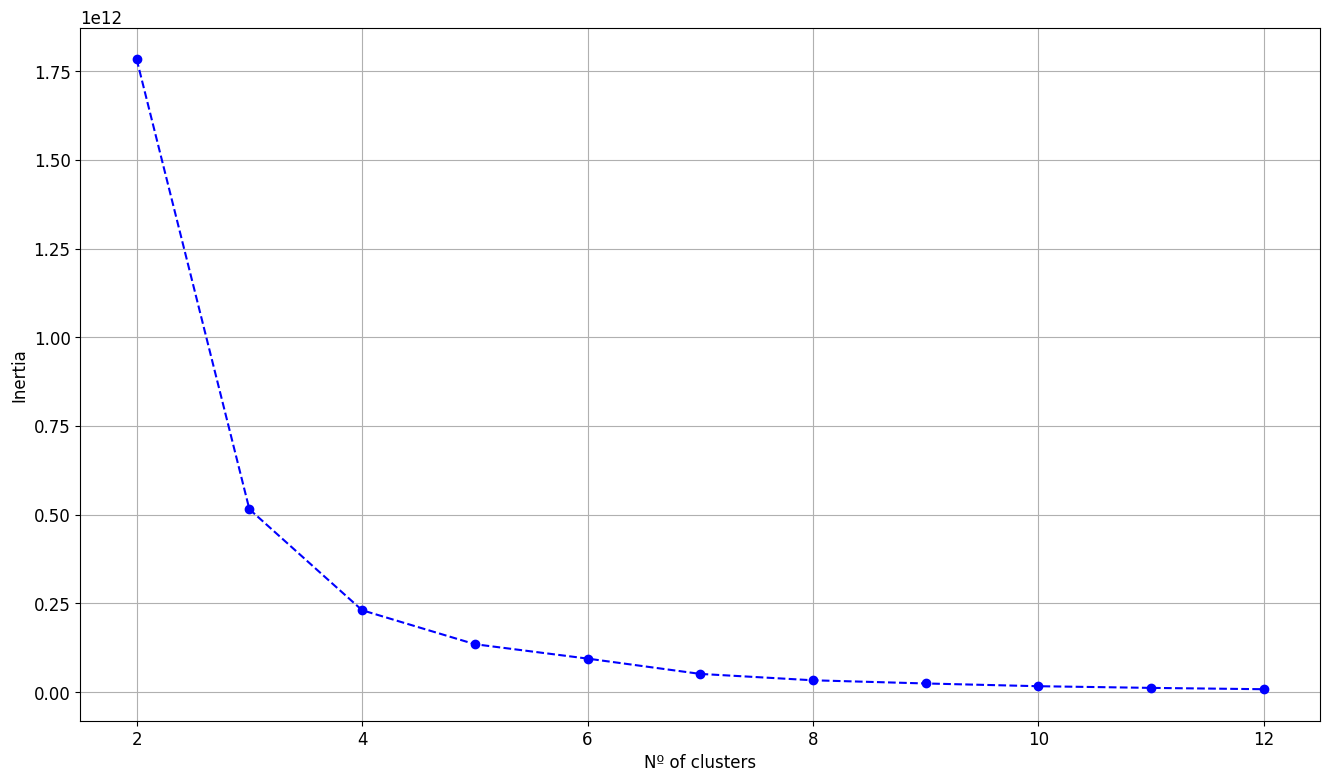

<Figure size 640x480 with 0 Axes>

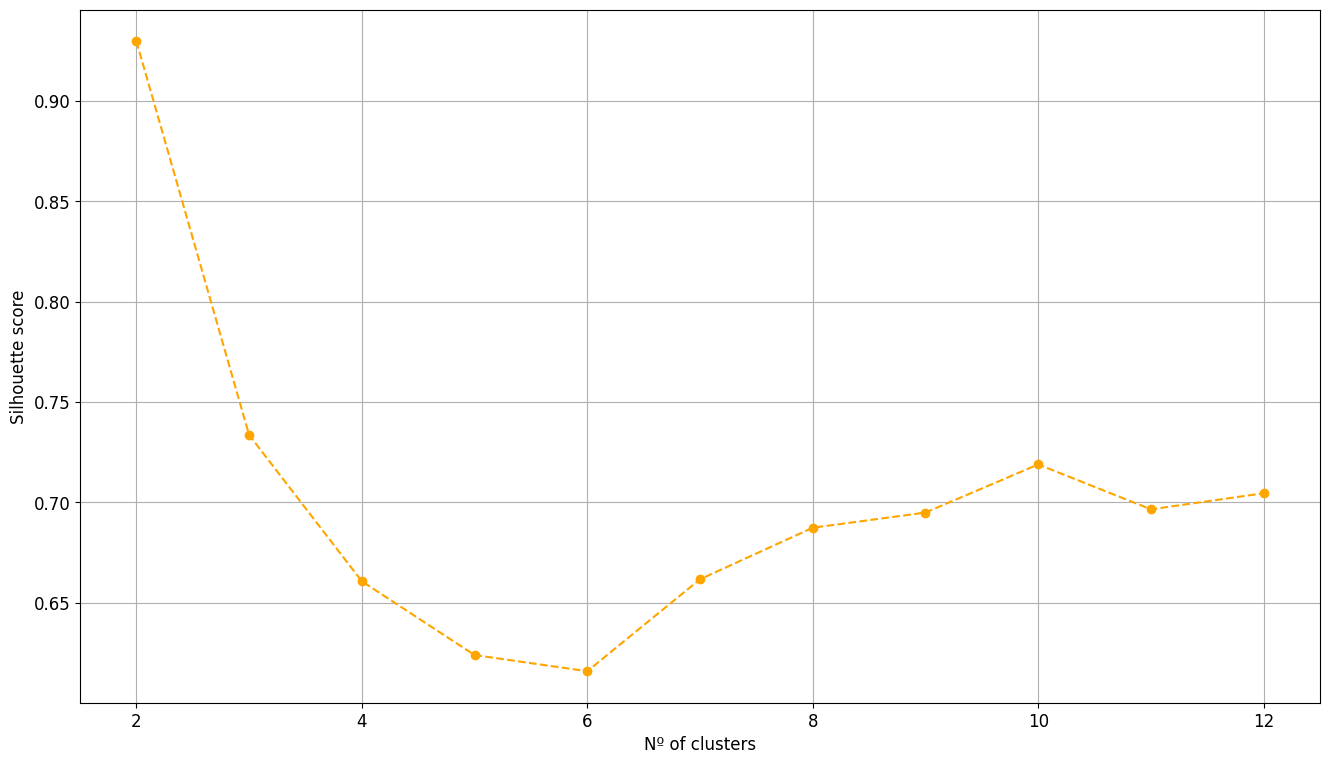

<Figure size 640x480 with 0 Axes>

In [ ]:
#K-means

cluster_data = cluster_data.filter(['sex', 'population', 'urbanization', 'avg_salary', 'unemployment96', 'entrepreneurs/1000', 'crimerate96', 'crimegrowth', 'unempgrowth', 'age_when_loan', "status"])

inertias = []
silhouettes = []
for n_clusters in range(2, 13):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(cluster_data)
    
    # Append the inertia value for each model
    inertias.append(kmeans.inertia_)
    
    # Compute the silhouette score for each model
    silhouette = silhouette_score(cluster_data, kmeans.labels_)
    silhouettes.append(silhouette)

# Use a scatter plot to visualize the data points and their assigned clusters
kmeans = KMeans(n_clusters=3).fit(cluster_data)
labels = kmeans.labels_

# Create a list of colors for each point in the dataset
colors_list = list(colors.cnames.keys())

# Create a scatter plot of the points, colored by their cluster labels
# plt.scatter(loans[:,0], loans[:,1], c=[colors_list[label] for label in labels])

# Plot the cluster centerseyy
# plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], marker='x')
# plt.show()
print("inertias", inertias)
print("silhouettes", silhouettes)

fig, ax = plt.subplots(figsize =(16, 9))

plt.plot(range(2, 13), inertias, '--bo', label='line with marker')
plt.grid()
plt.ylabel("Inertia") 
plt.xlabel("Nº of clusters")
plt.show()
plt.savefig('plots/k-means_inertia.png', transparent=True)

fig, ax = plt.subplots(figsize =(16, 9))

plt.plot(range(2, 13), silhouettes, '--o', color="orange", label='line with marker')
plt.grid()
plt.ylabel("Silhouette score") 
plt.xlabel("Nº of clusters")
plt.show()
plt.savefig('plots/k-means_silhouette.png', transparent=True)



inertias [9.812949131792648e+17, 9.812949131792648e+17, 9.812949131792648e+17, 9.812949131792648e+17, 9.812949131792648e+17, 9.812949131792648e+17, 9.812949131792648e+17, 9.812949131792648e+17, 9.812949131792648e+17, 9.812949131792648e+17, 9.812949131792648e+17]
silhouettes [0.9297508316370444, 0.7514648243379137, 0.5579686578171441, 0.6089550483901455, 0.6295909575651695, 0.6480994192334828, 0.6897249399114391, 0.7069067986677786, 0.6990193524487799, 0.7201248391677947, 0.7226628139349534]


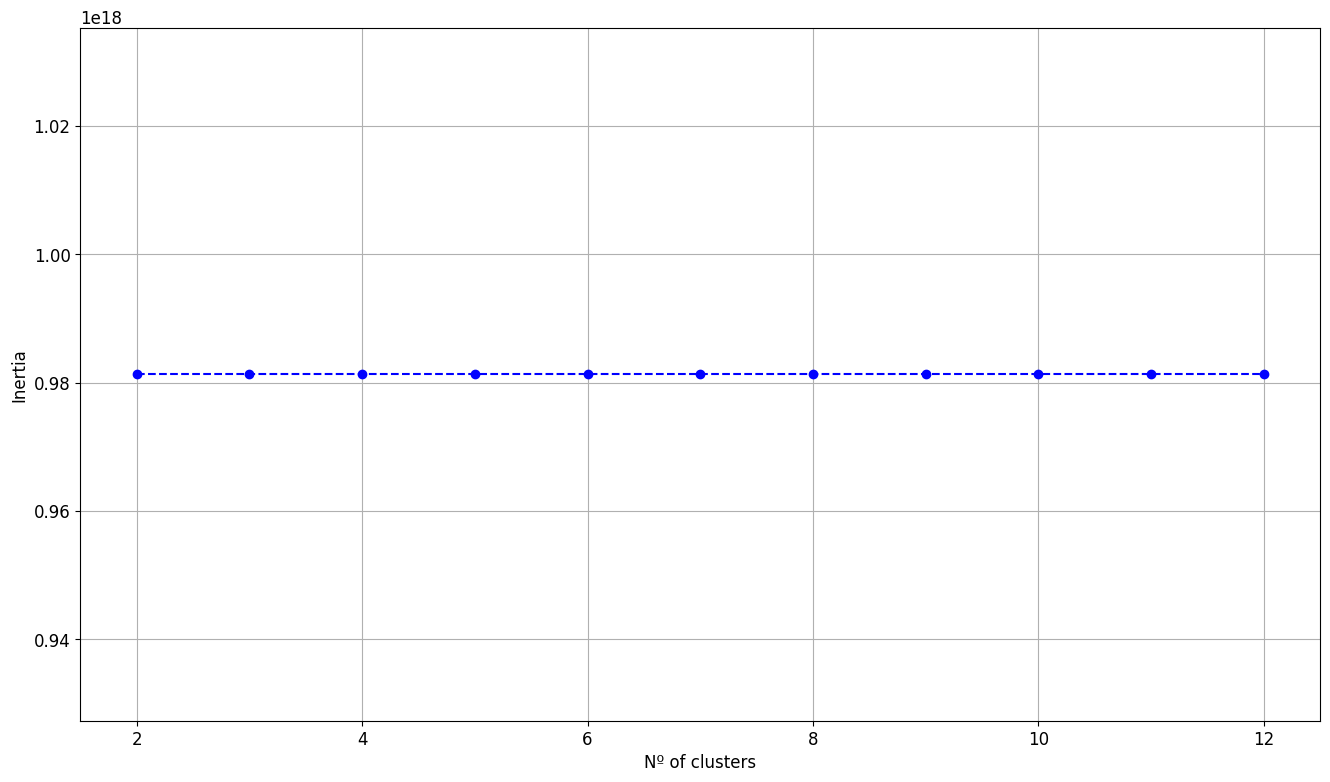

<Figure size 640x480 with 0 Axes>

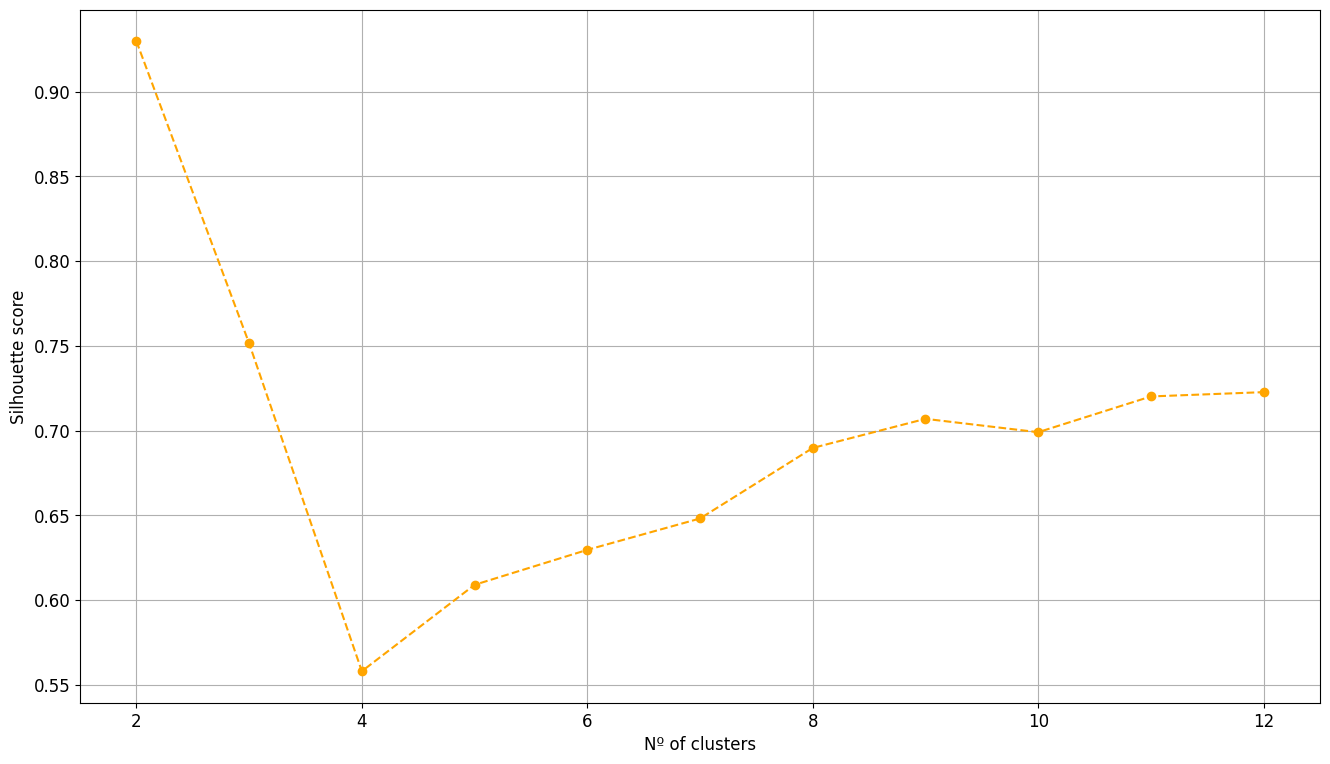

<Figure size 640x480 with 0 Axes>

In [ ]:
#AgglomerativeClustering

inertias = []
silhouettes = []
for n_clusters in range(2, 13):
    model = AgglomerativeClustering(n_clusters)
    model.fit(cluster_data)
    
    # Append the inertia value for each model
    # Compute the linkage matrix
    Z = linkage(cluster_data, method='ward')

    # Compute the cophenetic distances
    c, coph_dists = cophenet(Z, pdist(cluster_data))

    # Calculate the inertia of the model
    inertia = sum(coph_dists ** 2)
    inertias.append(inertia)
    
    # Compute the silhouette score for each model
    silhouette = silhouette_score(cluster_data, model.labels_)
    silhouettes.append(silhouette)

# Use a scatter plot to visualize the data points and their assigned clusters
# model = AgglomerativeClustering(n_clusters=3).fit(loans)
# labels = model.labels_

# Create a list of colors for each point in the dataset
# colors_list = list(colors.cnames.keys())

# Create a scatter plot of the points, colored by their cluster labels
# plt.scatter(loans[:,0], loans[:,1], c=[colors_list[label] for label in labels])

# Plot the cluster centerseyy
# plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], marker='x')
# plt.show()
print("inertias", inertias)
print("silhouettes", silhouettes)
fig, ax = plt.subplots(figsize =(16, 9))

plt.plot(range(2, 13), inertias, '--bo', label='line with marker')
plt.grid()
plt.ylabel("Inertia") 
plt.xlabel("Nº of clusters")
plt.show()
plt.savefig('plots/Nº_clusters_inertia.png', transparent=True)

fig, ax = plt.subplots(figsize =(16, 9))

plt.plot(range(2, 13), silhouettes, '--o', color="orange", label='line with marker')
plt.grid()
plt.ylabel("Silhouette score") 
plt.xlabel("Nº of clusters")
plt.show()
plt.savefig('plots/Nº_clusters_silhouette.png', transparent=True)



Index(['sex', 'population', 'urbanization', 'avg_salary', 'unemployment96',
       'entrepreneurs/1000', 'crimerate96', 'crimegrowth', 'unempgrowth',
       'age_when_loan', 'status'],
      dtype='object')


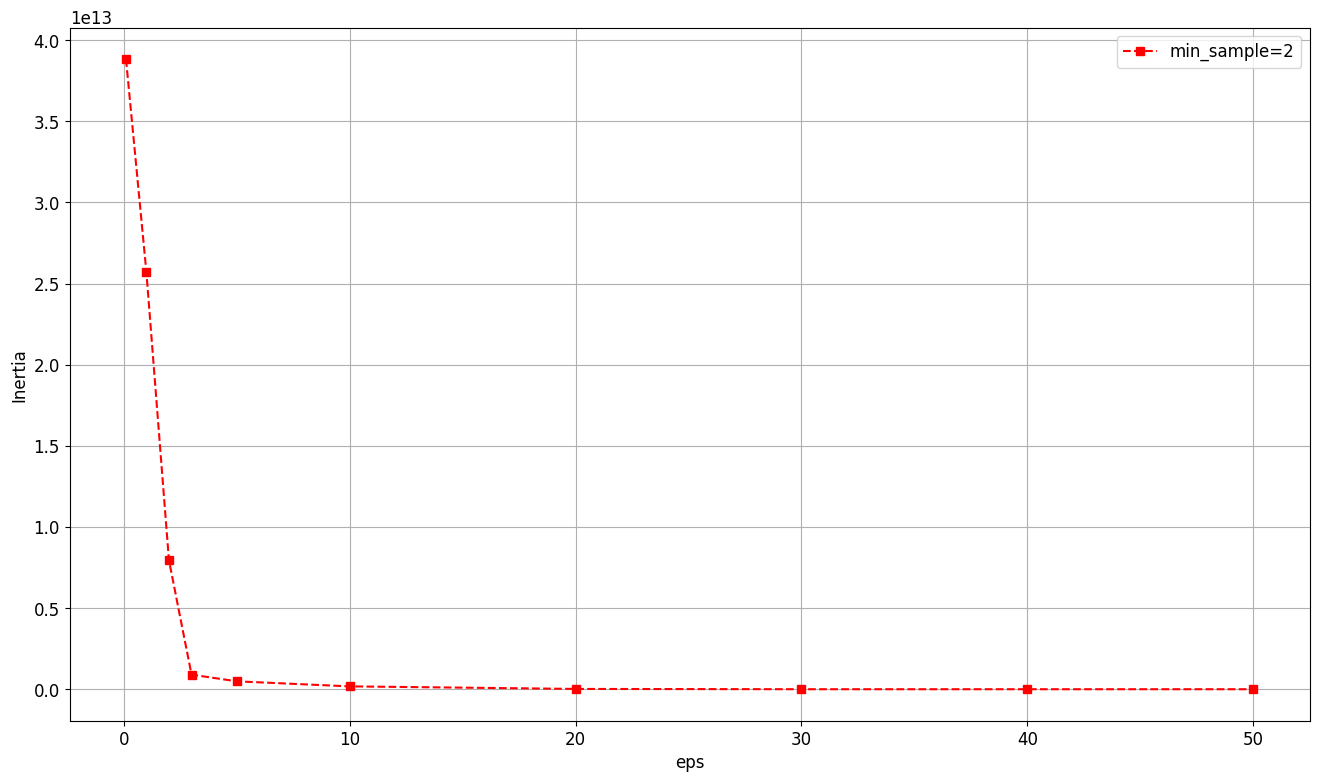

<Figure size 640x480 with 0 Axes>

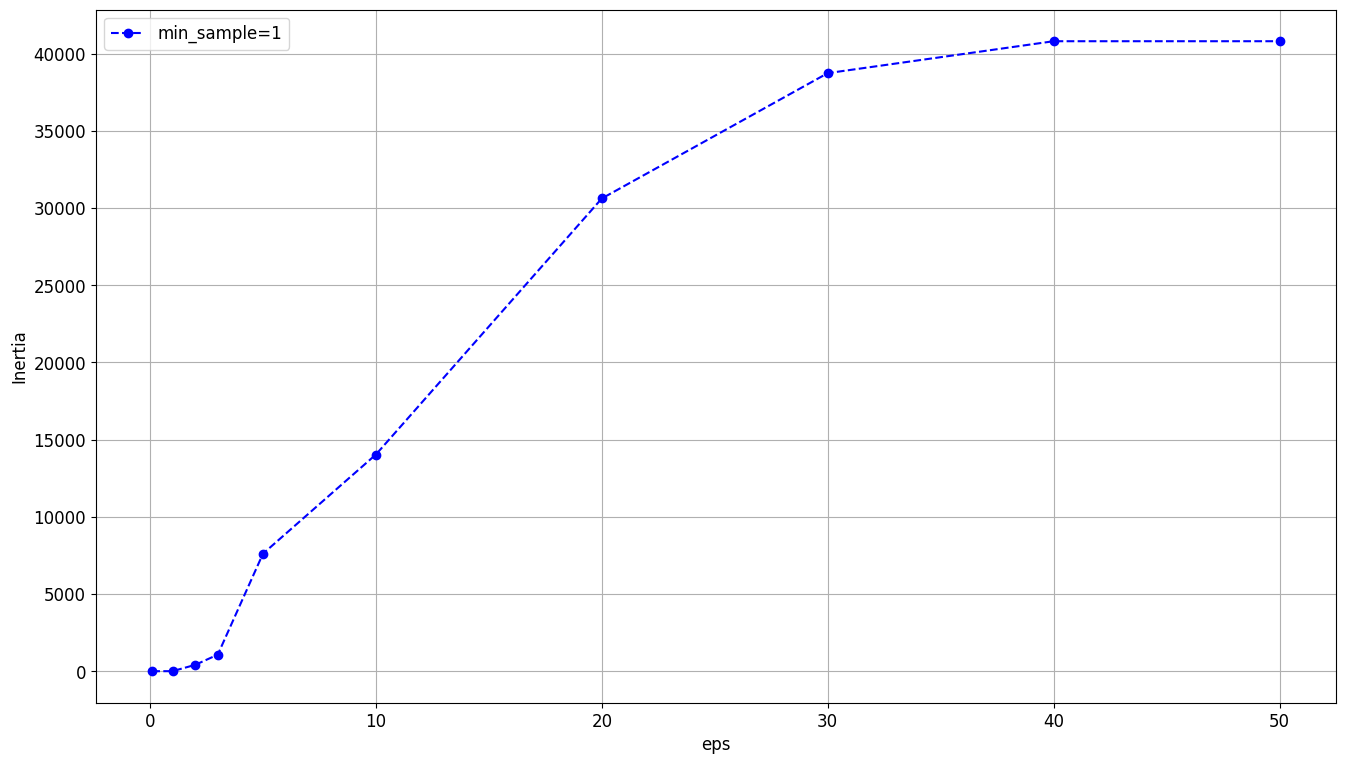

<Figure size 640x480 with 0 Axes>

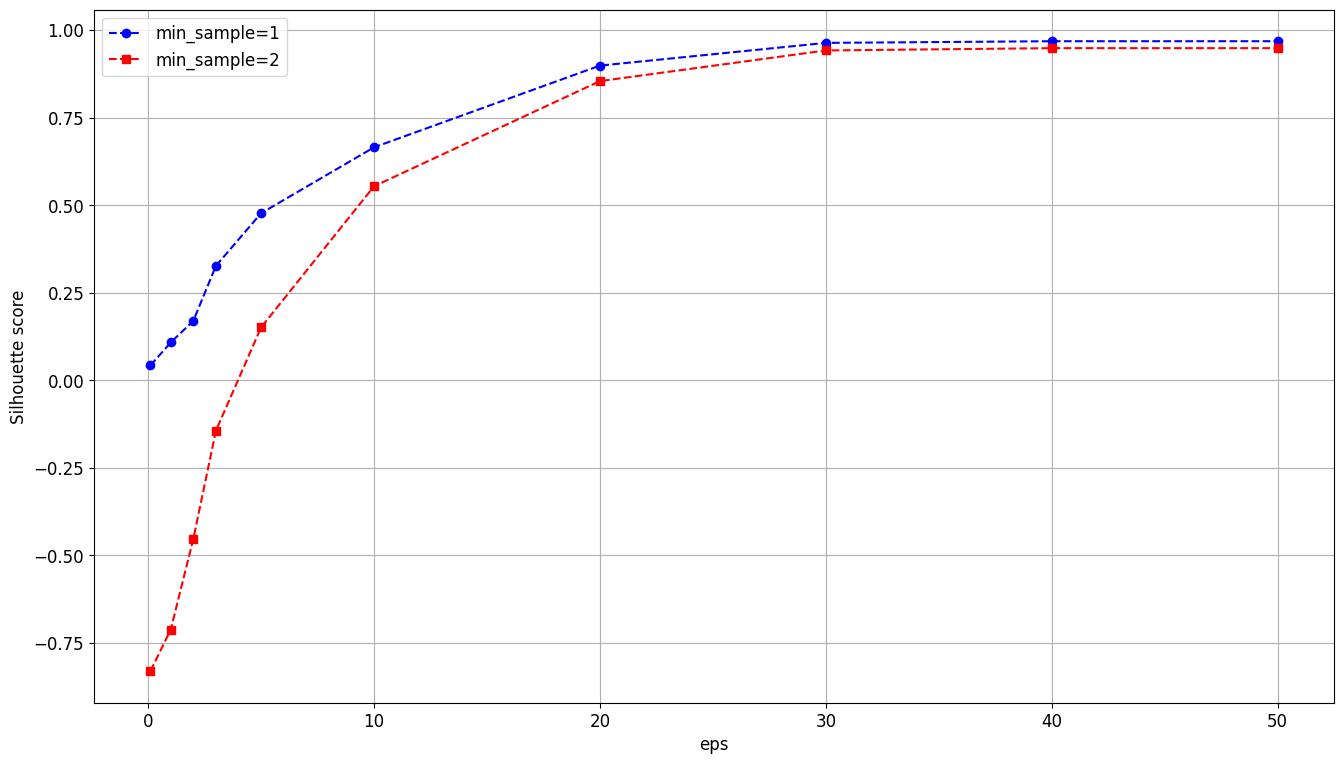

<Figure size 640x480 with 0 Axes>

In [ ]:
#DBSCAN

inertias_1 = []
inertias_2 = []
silhouettes_1 = []
silhouettes_2 = []


def compute_inertia(data, labels):
    # Initialize the inertia variable
    inertia = 0
    data = data.astype(float)

    
    # Loop over each cluster
    for i in np.unique(labels):
        # Get the data points in the current cluster
        cluster_points = data[labels == i]
        
        # Compute the mean of the data points in the current cluster
        cluster_mean = np.mean(cluster_points, axis=0)
        
        # Compute the sum of squares of the distances between the data points and the cluster mean
        cluster_inertia = np.sum(np.square(cluster_points - cluster_mean), axis=1)
        
        # Add the cluster inertia to the total inertia
        inertia += np.sum(cluster_inertia)
    
    # Return the total inertia
    return inertia

print(cluster_data.columns)
for ep in [0.1, 1, 2, 3, 5, 10, 20, 30, 40, 50]:
    for min_sample in [1, 2]:
        model = DBSCAN(eps=ep, min_samples=min_sample)
        model.fit(cluster_data)
        labels = model.labels_

        inertia = compute_inertia(cluster_data, labels)

        

        silhouette = silhouette_score(cluster_data, model.labels_)
        if min_sample == 1:
            inertias_1.append(inertia)
            silhouettes_1.append(silhouette)
        else:
            inertias_2.append(inertia)
            silhouettes_2.append(silhouette)

fig, ax = plt.subplots(figsize =(16, 9))

plt.plot([0.1, 1, 2, 3, 5, 10, 20, 30, 40, 50], inertias_2, '--rs', label='min_sample=2')
plt.grid()
plt.ylabel("Inertia") 
plt.xlabel("eps")
plt.legend(loc="upper right")
plt.show()
plt.savefig('plots/Eps_inertia_r.png', transparent=True)

fig, ax = plt.subplots(figsize =(16, 9))

plt.plot([0.1, 1, 2, 3, 5, 10, 20, 30, 40, 50], inertias_1, '--bo', label='min_sample=1')
plt.grid()
plt.ylabel("Inertia") 
plt.xlabel("eps")
plt.legend(loc="upper left")
plt.show()
plt.savefig('plots/Eps_inertia_l.png', transparent=True)

fig, ax = plt.subplots(figsize =(16, 9))

plt.plot([0.1, 1, 2, 3, 5, 10, 20, 30, 40, 50], silhouettes_1, '--bo', label='min_sample=1')
plt.plot([0.1, 1, 2, 3, 5, 10, 20, 30, 40, 50], silhouettes_2, '--rs', label='min_sample=2')
plt.grid()
plt.ylabel("Silhouette score") 
plt.xlabel("eps")
plt.legend(loc="upper left")
plt.show()
plt.savefig('plots/Eps_silhouetteia.png', transparent=True)



#### Plotting Clusters

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


db_score:  0.392728462780809
cluster_sizes: 
 [ 29  41  80 176]
columns:  RangeIndex(start=0, stop=10, step=1)


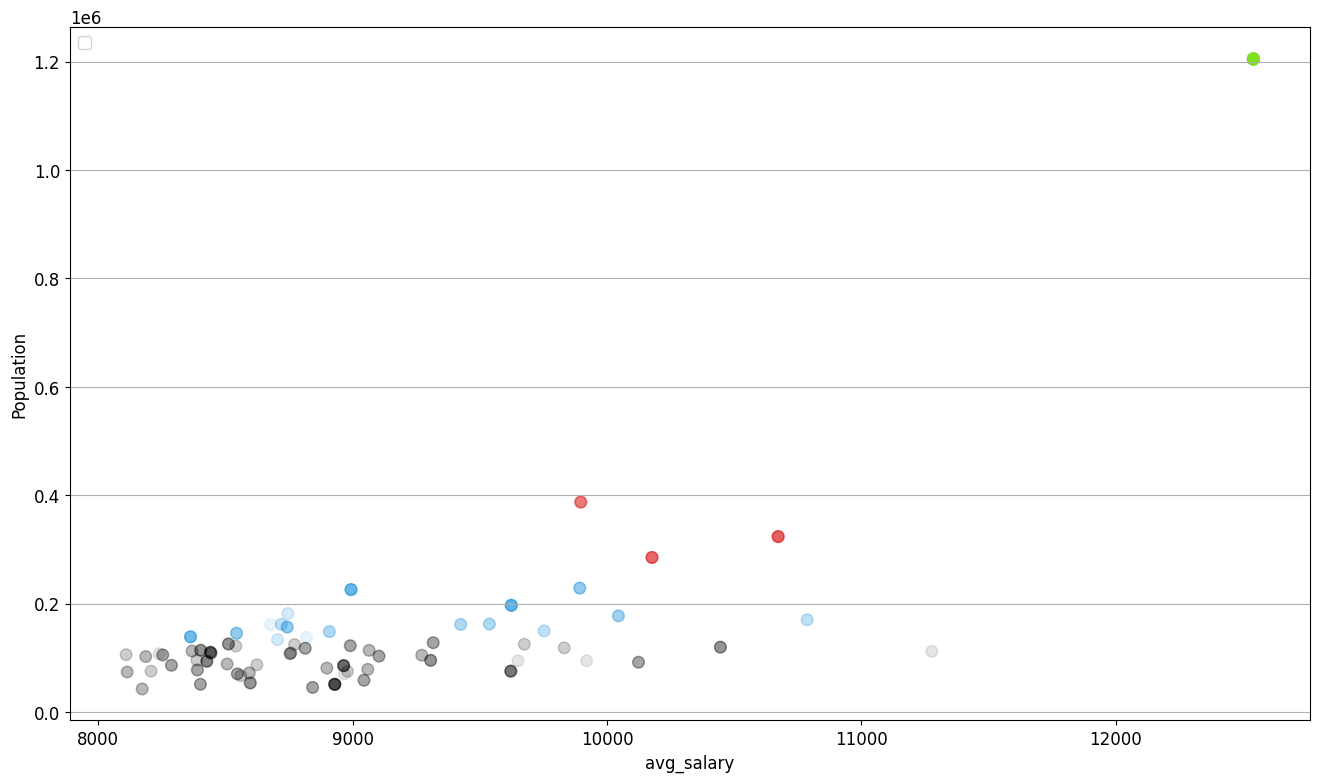

cluster_sizes: 
 [285  41]
columns:  RangeIndex(start=0, stop=10, step=1)


/usr/local/lib/python3.10/dist-packages/matplotlib/collections.py:1084: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


<Figure size 640x480 with 0 Axes>

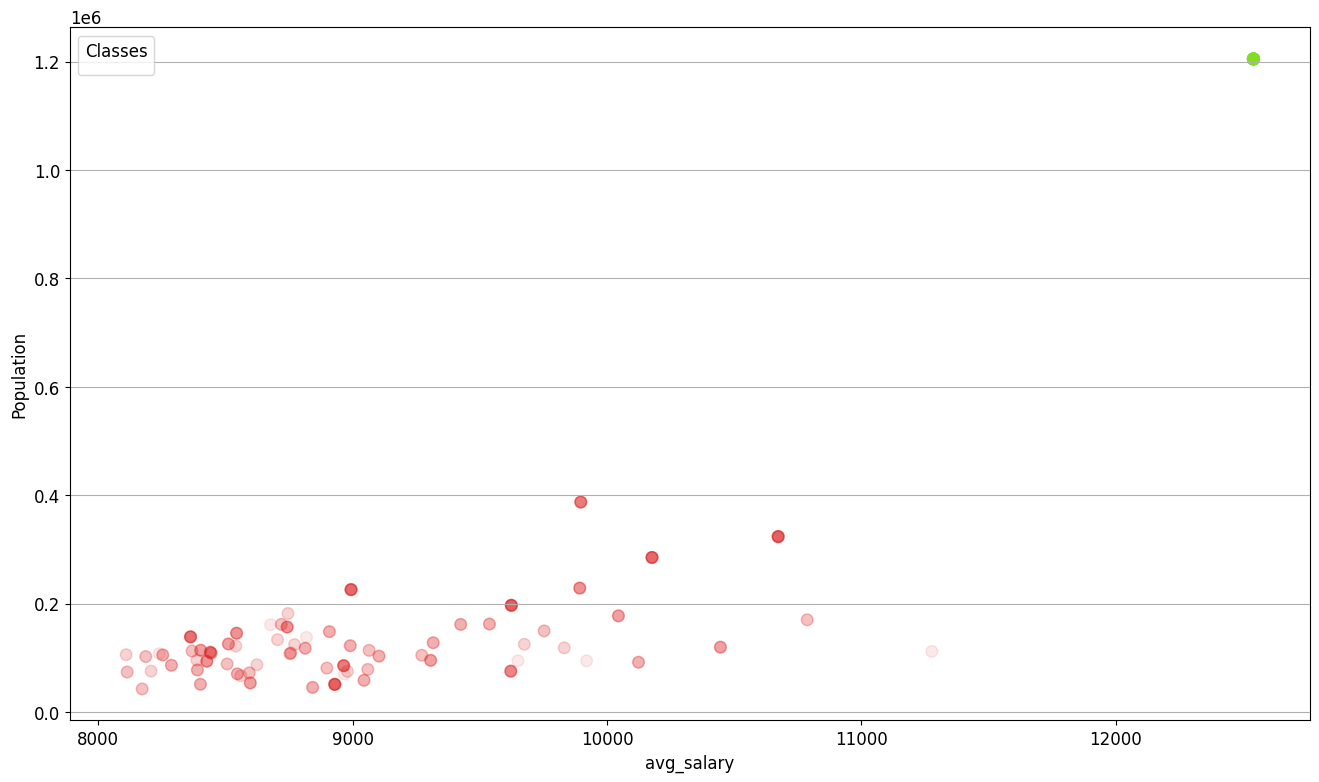

db_score:  0.01762509188482549
cluster_sizes: 
 [ 1  7  3 11 41  4  4 11 10  5  3  3  2  1  3  4  6  4 11  5  3  2  3  6
  5  4  4  3  2  1  4  2  4  5  2  2  9  6 10  4  5  6  2  4  8  2  1  1
  1  3  8  2  6  4  4  4  2  2  5  3  2  4  2  4  3  2  3  3  3  2  3  1
  1]
[[5.51724138e-01 3.28172414e+05 9.65172414e+01 1.02878966e+04
  5.27655172e+00 1.04482759e+02 4.70082739e-02 9.98875595e-01
  1.17542020e+00 3.52086667e+01 6.55172414e-01]
 [6.09756098e-01 1.20495300e+06 1.00000000e+02 1.25410000e+04
  4.30000000e-01 1.67000000e+02 8.22496811e-02 1.15675152e+00
  1.48275862e+00 3.81673094e+01 7.07317073e-01]
 [5.50000000e-01 1.75349825e+05 6.30337500e+01 9.20053750e+03
  3.48325000e+00 1.16437500e+02 2.78821521e-02 1.00935227e+00
  1.29672119e+00 3.64560233e+01 8.00000000e-01]
 [4.54545455e-01 9.07953920e+04 5.79863636e+01 8.85104545e+03
  3.97170455e+00 1.15931818e+02 2.91420908e-02 1.04955418e+00
  1.22329991e+00 3.60715419e+01 6.93181818e-01]]


<Figure size 640x480 with 0 Axes>

In [ ]:
#K-means
cluster_data_kmean = cluster_data.copy()
cluster_data_agglomerative = cluster_data.copy()
cluster_data_dbscan = cluster_data.copy()

kmeans = KMeans(n_clusters=4)
labels = kmeans.fit_predict(cluster_data_kmean)
db_score = davies_bouldin_score(cluster_data_kmean, labels)
print("db_score: ", db_score)
cluster_data_kmean['cluster'] = labels
# get centroids
centroids = kmeans.cluster_centers_

cluster_sizes = np.bincount(labels)
print("cluster_sizes: \n", cluster_sizes)


# print(centroids)
cen_x = [i[0] for i in centroids] 
cen_y = [i[1] for i in centroids]
## add to df
cluster_data_kmean['cen_x'] = cluster_data_kmean["cluster"].map({0:cen_x[0], 1:cen_x[1], 2:cen_x[2], 3:cen_x[3]})
cluster_data_kmean['cen_y'] = cluster_data_kmean["cluster"].map({0:cen_y[0], 1:cen_y[1], 2:cen_y[2], 3:cen_y[3]})
# define and map colors
colors = ['#DF2020', '#81DF20', '#2095DF', '#000000']
cluster_data_kmean['c'] = cluster_data_kmean["cluster"].map({0:colors[0], 1:colors[1], 2:colors[2], 3:colors[3]})

print("columns: ", df.columns)

fig, ax = plt.subplots(figsize =(16, 9))

plt.scatter(cluster_data_kmean["avg_salary"], cluster_data_kmean["population"], c=cluster_data_kmean["c"], s=70, alpha=0.1)
plt.ylabel("Population") 
plt.xlabel("avg_salary")
plt.legend(loc="upper left")
plt.grid(axis="y")
plt.show()
plt.savefig('plots/k-mean_cluster.png', transparent=True)
#AgglomerativeClustering

model = AgglomerativeClustering(n_clusters=2)
labels = model.fit_predict(cluster_data_agglomerative)
db_score = davies_bouldin_score(cluster_data_agglomerative, labels)
print("db_score: ", db_score)
cluster_data_agglomerative['cluster'] = labels

cluster_sizes = np.bincount(labels)
print("cluster_sizes: \n", cluster_sizes)



cluster_data_agglomerative['cen_x'] = cluster_data_agglomerative["cluster"].map({0:cen_x[0], 1:cen_x[1]})
cluster_data_agglomerative['cen_y'] = cluster_data_agglomerative["cluster"].map({0:cen_y[0], 1:cen_y[1]})
# define and map colors
colors = ['#DF2020', '#81DF20']
cluster_data_agglomerative['c'] = cluster_data_agglomerative["cluster"].map({0:colors[0], 1:colors[1]})

print("columns: ", df.columns)

fig, ax = plt.subplots(figsize =(16, 9))

scatter = plt.scatter(cluster_data_agglomerative["avg_salary"], cluster_data_agglomerative["population"], c=cluster_data_agglomerative["c"], s=70, alpha=0.1)
plt.ylabel("Population") 
plt.xlabel("avg_salary")
ax.legend(*scatter.legend_elements(),
                    loc="upper left", title="Classes")
plt.grid(axis="y")
plt.show()
plt.savefig('plots/agglomerative_cluster.png', transparent=True)

#DBSCAN

model = DBSCAN(eps=30, min_samples=1)
labels = model.fit_predict(cluster_data)
db_score = davies_bouldin_score(cluster_data, labels)
print("db_score: ", db_score)
cluster_data['cluster'] = labels

centroids = kmeans.cluster_centers_


cluster_sizes = np.bincount(labels)
print("cluster_sizes: \n", cluster_sizes)

print(centroids)



### Outlier Removal

Now that we have a dataset that combines all the initial datasets, we define a function for removing outliers, based on 1.5x inter-quartile rule. After that we apply it to the amount and duration columns.

amount
[ 10  45  57  68 116 122 131 176 191 209 262 293]
[]
average_balance_fluctuation_per_month
[  2  27  32  41  42  50  62  89  91 119 128 132 145 149 153 196 208 221
 229 251 254 306]
[101 102 122 143 189 192 210]
avg_balance
[]
[]


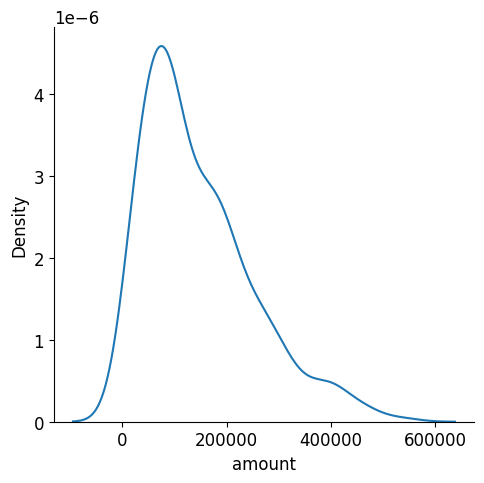

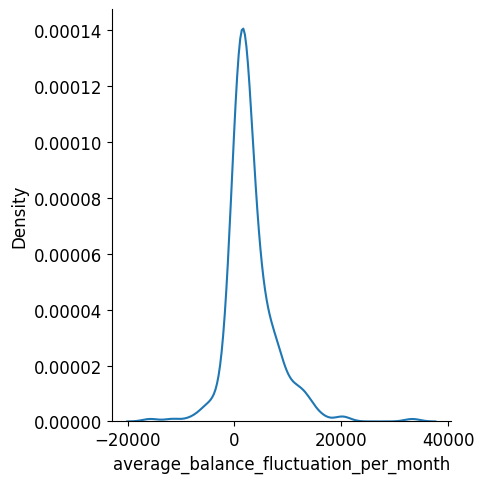

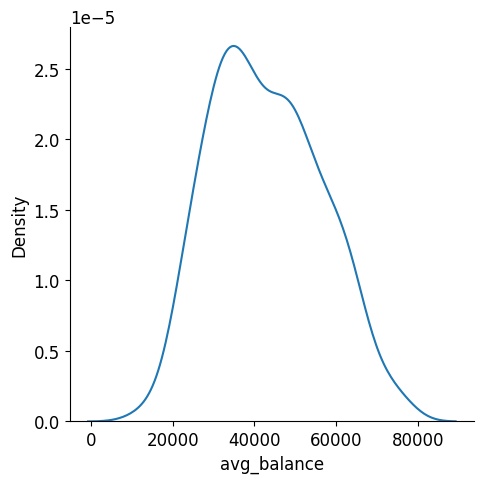

In [ ]:

def remove_outliers(df,column):
    Q1 = np.percentile(df[column], 25,
                    method = 'midpoint')
    
    Q3 = np.percentile(df[column], 75,
                    method = 'midpoint')
    IQR = Q3 - Q1
    # Upper bound
    upper = np.where(df[column] >= (Q3+1.5*IQR))
    # Lower bound
    lower = np.where(df[column] <= (Q1-1.5*IQR))
    print(column)

    print(upper[0])
    print(lower[0])

    df.drop(upper[0], inplace = True)
    df.drop(lower[0], inplace = True)
    df.reset_index(drop=True,inplace=True)

#Check if values have a near-normal distribution and then remove outliers
    
sns.displot(loans,x='amount',kind="kde")
remove_outliers(loans,'amount')

sns.displot(loans,x='average_balance_fluctuation_per_month',kind="kde")
remove_outliers(loans,'average_balance_fluctuation_per_month')

sns.displot(loans,x='avg_balance',kind="kde")
remove_outliers(loans,'avg_balance')

In [ ]:
def drop_cols_and_nas(loans):
    # removed strings, dates and columns with high number of NaN values
    data=loans.drop(columns=['frequency','name_branch','region_branch','name','region'])

    # removing rows with NaN values
    print("Before NaN removal:"+str(len(data)))

    data.dropna(axis=0,inplace=True)

    print("After NaN removal:"+str(len(data)))
    return data

data = drop_cols_and_nas(loans)

Before NaN removal:285
After NaN removal:285


Update category columns to use category types.

In [ ]:
def category_treatment(data):
  cat_cols = ["sex", "code", "code_branch"]
  categorical_indexes=[]
  for col in cat_cols:
    categorical_indexes.append(data.columns.get_loc(col))
    data[col] = data[col].astype('category')
  return data, categorical_indexes

data, categorical_indexes = category_treatment(data)
data.dtypes

loan_id                                     int64
amount                                      int64
duration                                    int64
payments                                    int64
status                                      int64
num_clients                                 int64
sex                                      category
has_card                                    int64
num_salaries                              float64
average_balance_fluctuation_per_month     float64
recent_balance                            float64
num_household_payments                    float64
num_payments_for_statement                float64
num_insurrance_payments                   float64
num_sanction_payments                     float64
num_interests_credited                    float64
ratio_credits                             float64
avg_balance                               float64
min_balance                               float64
max_balance                               float64


Finally we split the data for training and testing.

In [ ]:
def split(data):
    labels=data.loc[:,"status"]
    data_without_labels=data.drop(columns="status")
    return data_without_labels, labels

data_without_labels, labels = split(data)

## Classification

As by default algorithms treat 1 as positive value, we update so 1 -> 0 and our target, -1 -> 1

In [ ]:
labels = labels.replace(1,0)
labels = labels.replace(-1,1)

In [ ]:
def plot_confusion_matrix(actual_classes,predicted_classes):

    matrix = confusion_matrix(actual_classes, predicted_classes)
    tn, fp, fn, tp = confusion_matrix(actual_classes, predicted_classes).ravel()
    npv=tn/(tn+fn)
    fpr=fp/(fp+tn)
    print("Negative Predictive Value: " + str(npv))
    print("False Positive Rate: " + str(fpr))

    plt.figure(figsize=(12.8,6))
    sns.heatmap(matrix, annot=True, cmap="Blues", fmt="g")
    plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix')

    plt.show()

In [ ]:
def curve(model, testX, testy):
    ns_probs = [0 for _ in range(len(testy))]
    mod_probs = model.predict_proba(testX)
    # keep probabilities for the fail outcome
    neg_probs = []
    for prob in mod_probs:
        neg_probs.append(prob[1])
    ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs, pos_label=1)
    lr_fpr, lr_tpr, _ = roc_curve(testy, neg_probs, pos_label=1)
    # plot the roc curve for the model
    pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Model')
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    pyplot.legend()
    pyplot.show()
    display = PrecisionRecallDisplay.from_estimator(model, testX, testy, pos_label=1)
    _ = display.ax_.set_title("2-class Precision-Recall curve")

In [ ]:
def importances(model):
    feat_importances = pd.Series(model[1].feature_importances_, index=data_without_labels.columns)
    feat_importances.nlargest(20).plot(kind='barh')


In [ ]:
def logregcoef(model):
    feat_coefs = pd.Series(model[1].coef_[0], index=data_without_labels.columns)
    feat_coefs.nlargest(20).plot(kind='barh')

### Without Cross-Validation

At the start we test the 4 algorithms (Logistic Regression, Random Forest, SVM and Naive Bayes) with our only treatment being the use of scaling.
In this case we also print the coefficients of logistic regression and feature importance of Random Forest to get an early idea of our more important classes.
Given the class imbalance, we print F1 scores.

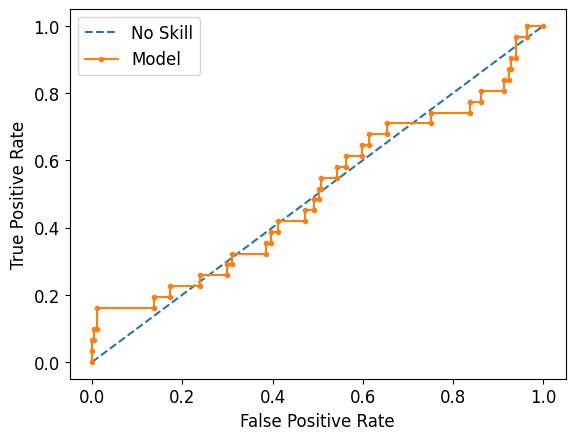

Negative Predictive Value: 0.874439461883408
False Positive Rate: 0.01015228426395939


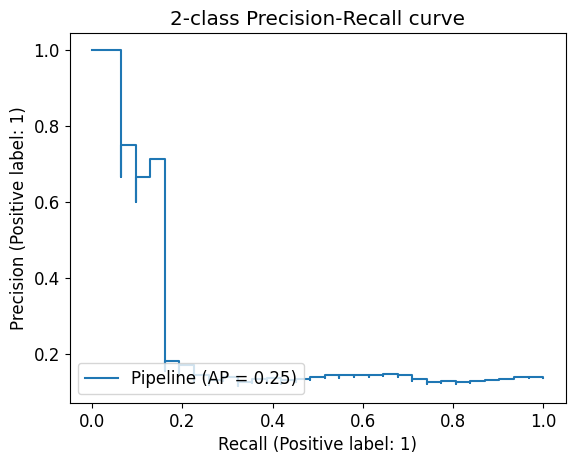

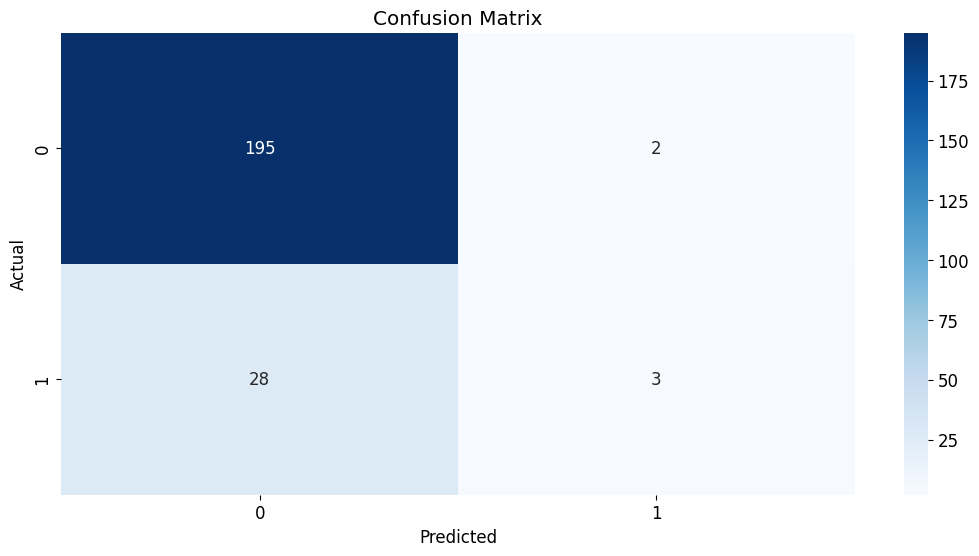


Logistic Regression Score: 0.868421052631579

Logistic Regression F1 Score: 0.8249791144527987


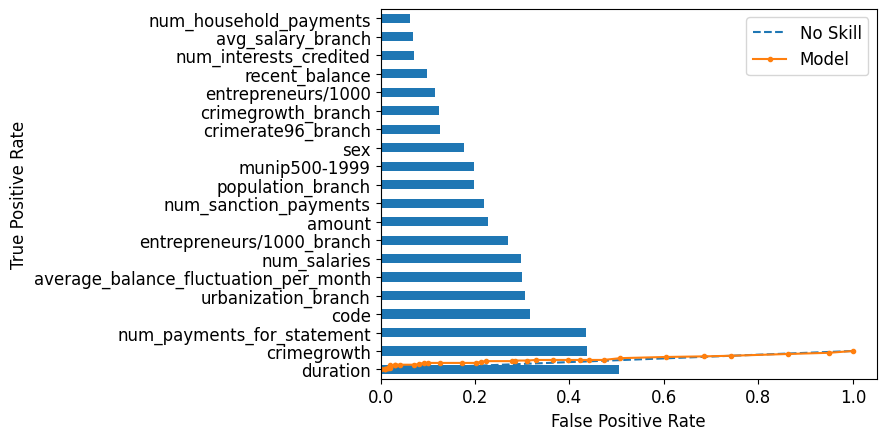

Negative Predictive Value: 0.8628318584070797
False Positive Rate: 0.01015228426395939


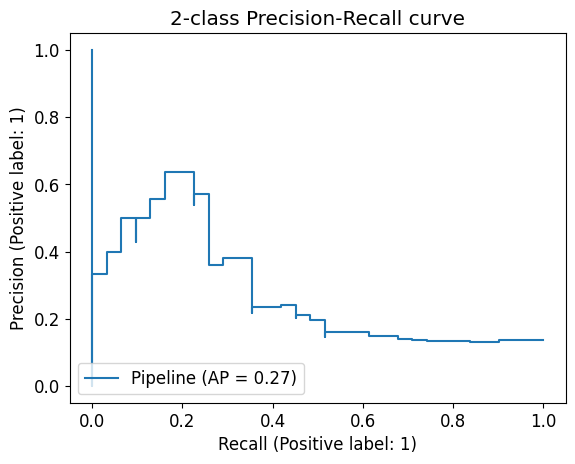

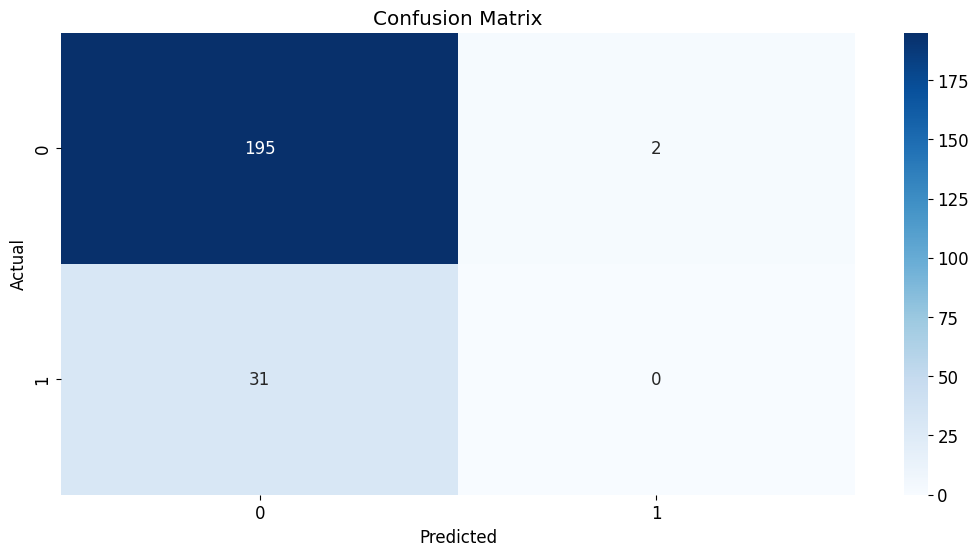


Random Forest Score: 0.8552631578947368

Random Forest F1 Score: 0.7966280950603459


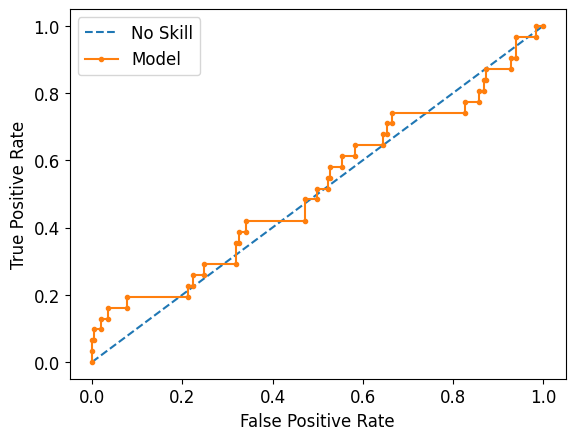

Negative Predictive Value: 0.8640350877192983
False Positive Rate: 0.0


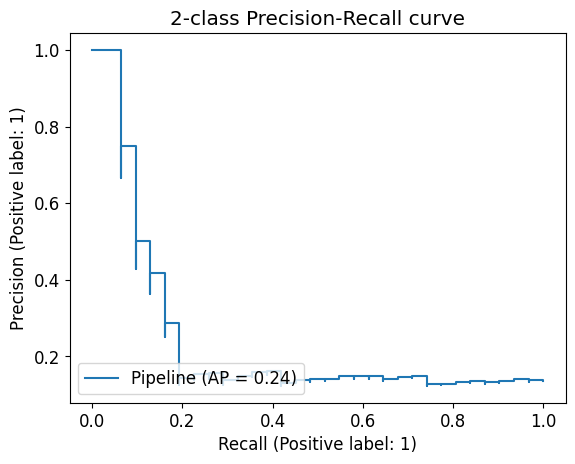

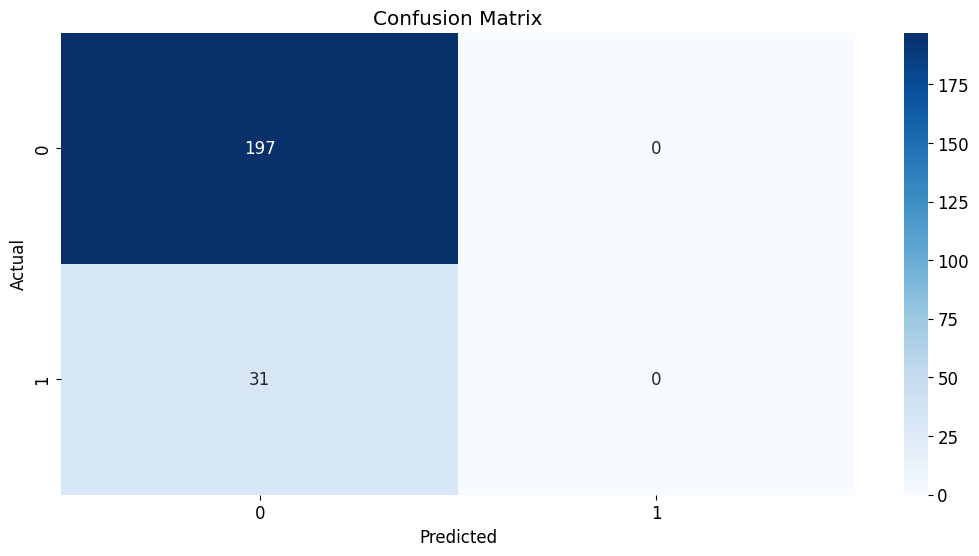


SVM Score: 0.8640350877192983

SVM F1 Score: 0.8010113519091847


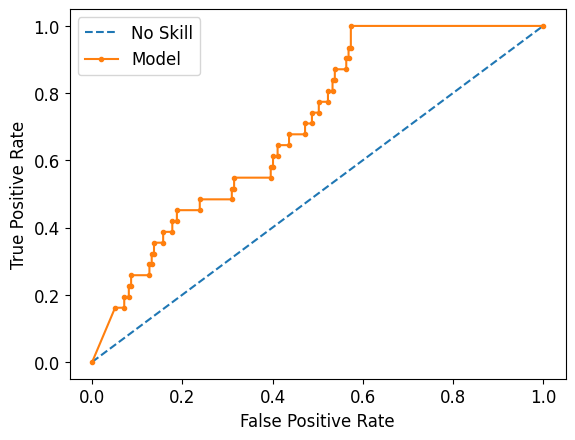

Negative Predictive Value: 0.9030303030303031
False Positive Rate: 0.2436548223350254


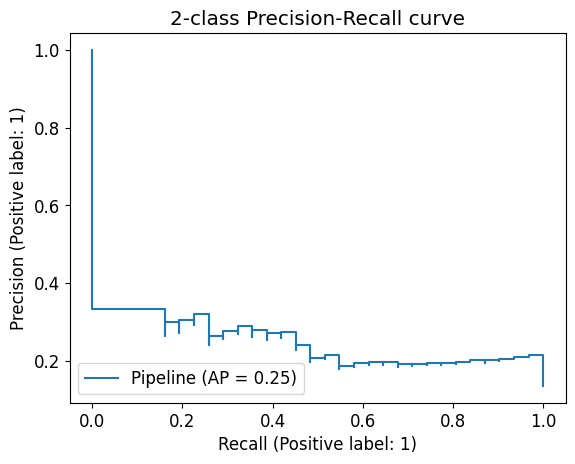

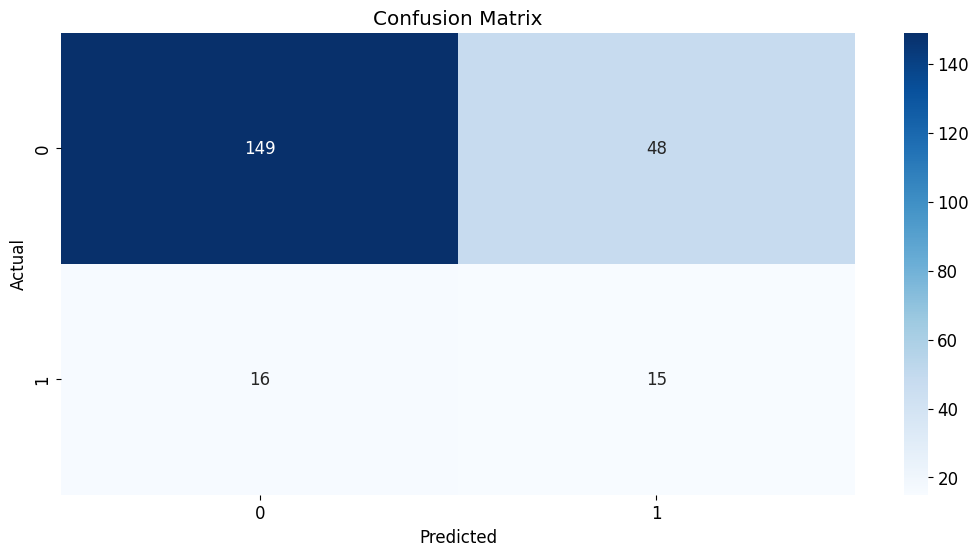


NB Score: 0.7192982456140351

NB F1 Score: 0.7546705602610029


In [ ]:
x_train,x_test,y_train,y_test=train_test_split(data_without_labels,labels,train_size=0.2,random_state=0)

###Logistic Regression
pipe = make_pipeline(StandardScaler(), LogisticRegression())

pipe.fit(x_train, y_train)
curve(pipe,x_test,y_test)
predictions = pipe.predict(x_test)

logistic_regr_score = pipe.score(x_test, y_test)
f1_score_results=f1_score(y_test,predictions,average='weighted')

plot_confusion_matrix(y_test,predictions)
logregcoef(pipe)
print("\nLogistic Regression Score: " + str(logistic_regr_score))
print("\nLogistic Regression F1 Score: " + str(f1_score_results))

###Random Forest
pipe = make_pipeline(StandardScaler(), RandomForestClassifier())

pipe.fit(x_train, y_train)
curve(pipe,x_test,y_test)

predictions = pipe.predict(x_test)

random_forest_score = pipe.score(x_test, y_test)
f1_score_results=f1_score(y_test,predictions,average='weighted')
plot_confusion_matrix(y_test,predictions)
#importances(pipe)
print("\nRandom Forest Score: " + str(random_forest_score))
print("\nRandom Forest F1 Score: " + str(f1_score_results))

###SVM
pipe = make_pipeline(StandardScaler(), SVC(probability=True))

pipe.fit(x_train, y_train)
curve(pipe,x_test,y_test)

predictions = pipe.predict(x_test)

svm_score = pipe.score(x_test, y_test)
f1_score_results=f1_score(y_test,predictions,average='weighted')
plot_confusion_matrix(y_test,predictions)
print("\nSVM Score: " + str(svm_score))
print("\nSVM F1 Score: " + str(f1_score_results))

###Naive Bayes
pipe = make_pipeline(StandardScaler(), GaussianNB())

pipe.fit(x_train, y_train)
curve(pipe,x_test,y_test)

predictions = pipe.predict(x_test)

nb_score = pipe.score(x_test, y_test)
f1_score_results=f1_score(y_test,predictions,average='weighted')
plot_confusion_matrix(y_test,predictions)
print("\nNB Score: " + str(nb_score))
print("\nNB F1 Score: " + str(f1_score_results))

Our choice of data extraction out of transactions was wise, as these proved to be the most important features.

### With Cross-Validation

#### No Sampling

Avg AUC for Logistic Regression: 0.6500204081632652
Avg f-score for Logistic Regression: 0.8548291992932434
Avg f-score for Logistic Regression defaulted: 0.38853695324283555
Avg f-score for Logistic Regression paid: 0.922522908865967
Avg f-score for Logistic Regression paid: 0.922522908865967
Negative Predictive Value: 0.91015625
False Positive Rate: 0.0642570281124498


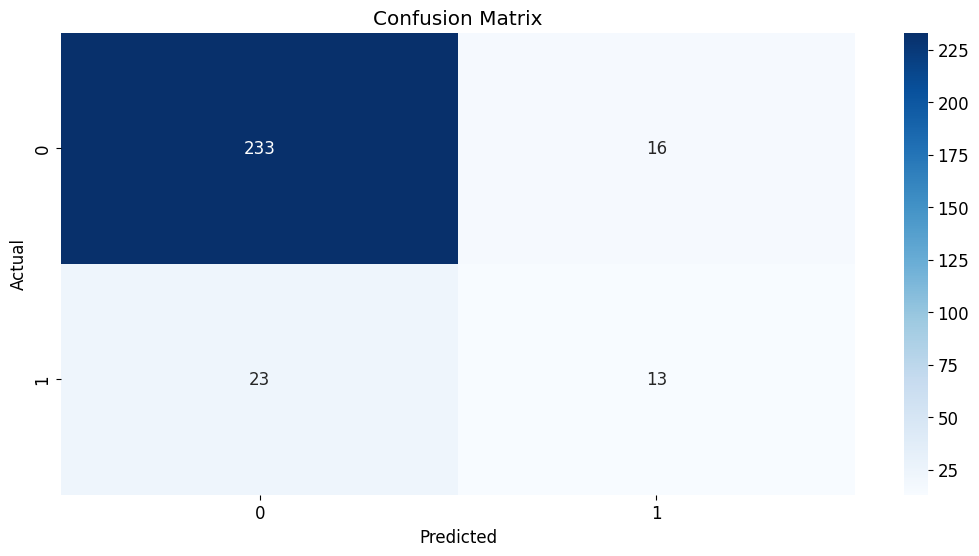

Avg AUC for Random Forest: 0.6209183673469388
Avg f-score for Random Forest: 0.8702672240315172
Avg f-score for Random Forest defaulted: 0.35666666666666663
Avg f-score for Random Forest paid: 0.9445242432390668
Avg f-score for Random Forest paid: 0.9445242432390668
Negative Predictive Value: 0.9014598540145985
False Positive Rate: 0.008032128514056224


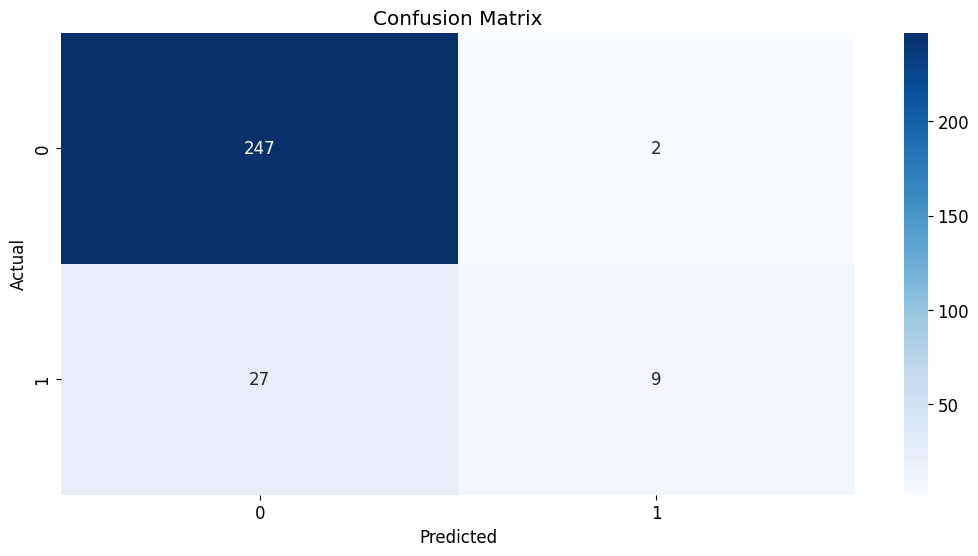

Avg AUC for SVM: 0.5285714285714286
Avg f-score for SVM: 0.8288384610893405
Avg f-score for SVM defaulted: 0.08888888888888889
Avg f-score for SVM paid: 0.9361295144049508
Avg f-score for SVM paid: 0.9361295144049508
Negative Predictive Value: 0.8798586572438163
False Positive Rate: 0.0


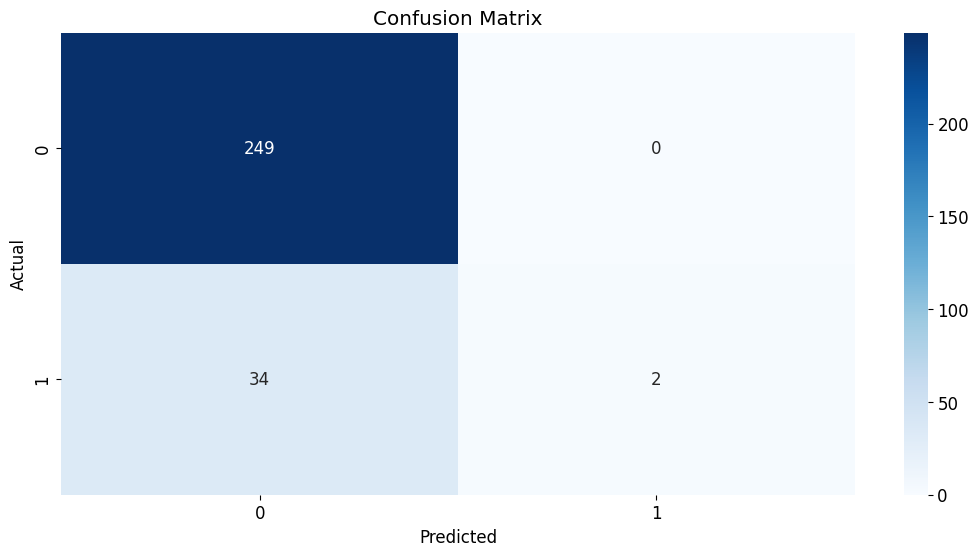

Avg AUC for Naive Bayes: 0.6994795918367347
Avg f-score for Naive Bayes: 0.5984814033822108
Avg f-score for Naive Bayes defaulted: 0.3293858003357362
Avg f-score for Naive Bayes paid: 0.6376284720192436
Avg f-score for Naive Bayes paid: 0.6376284720192436
Negative Predictive Value: 0.9752066115702479
False Positive Rate: 0.5261044176706827


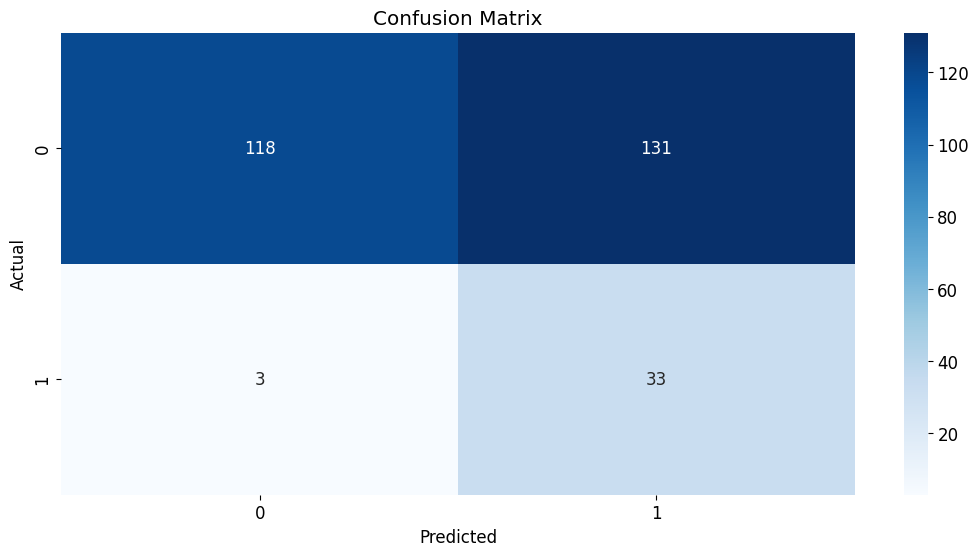

In [ ]:
def crossval(model, modelname, splits, sampler = None):
    cv = StratifiedKFold(n_splits=splits)
    score = 0
    score_pos = 0
    score_neg = 0
    auc=0
    fold = 0
    actual_classes = np.empty([0], dtype=int)
    predicted_classes = np.empty([0], dtype=int)
    for train_idx, test_idx, in cv.split(data_without_labels, labels):
        fold += 1
        X_train, y_train = data_without_labels.iloc[train_idx], labels.iloc[train_idx]
        X_test, y_test = data_without_labels.iloc[test_idx], labels.iloc[test_idx]
        if sampler is not None:
            X_train, y_train = sampler.fit_resample(X_train, y_train)
            X_train = X_train.apply(lambda x: x.fillna(x.value_counts().index[0])) #smote generated NaNs somehow

        model = make_pipeline(StandardScaler(), model)
        model.fit(X_train, y_train)  
        y_pred = model.predict(X_test)
        
        actual_classes = np.append(actual_classes, y_test)
        predicted_classes = np.append(predicted_classes, y_pred)
        f1_score_fold = f1_score(y_test, y_pred,average='weighted')
        f1_score_fold_pos = f1_score(y_test, y_pred,average='binary',pos_label=1)
        f1_score_fold_neg = f1_score(y_test, y_pred,average='binary',pos_label=0)
        auc_score_fold=roc_auc_score(y_test, y_pred)

        auc+=auc_score_fold
        score += f1_score_fold
        score_pos += f1_score_fold_pos
        score_neg += f1_score_fold_neg
    
    auc=auc/splits
    score = score / splits
    score_pos = score_pos / splits
    score_neg = score_neg / splits

    print(f'Avg AUC for {modelname}: {auc}')
    print(f'Avg f-score for {modelname}: {score}')
    print(f'Avg f-score for {modelname} defaulted: {score_pos}')
    print(f'Avg f-score for {modelname} paid: {score_neg}')
    print(f'Avg f-score for {modelname} paid: {score_neg}')

    plot_confusion_matrix(actual_classes,predicted_classes)
    return score, score_pos, score_neg

cv_lg_f1, cv_lg_f1_pos, cv_lg_f1_neg = crossval(LogisticRegression(), "Logistic Regression", 5)
cv_rfg_f1, cv_rfg_f1_pos, cv_rfg_f1_neg = crossval(RandomForestClassifier(), "Random Forest", 5)
cv_svm_f1, cv_svm_f1_pos, cv_svm_f1_neg = crossval(SVC(), "SVM", 5)
cv_nb_f1, cv_nb_f1_pos, cv_nb_f1_neg= crossval(GaussianNB(), "Naive Bayes", 5)

By displaying the f1 score for each class individually its notable that the models still fail at reliably classifying the smaller, "default" class which under and over sampling can hopefully remedy.

#### Undersampling

Avg AUC for Logistic Regression: 0.6890896921017403
Avg f-score for Logistic Regression: 0.7829622988600313
Avg f-score for Logistic Regression defaulted: 0.3860587297119804
Avg f-score for Logistic Regression paid: 0.8403459474115568
Avg f-score for Logistic Regression paid: 0.8403459474115568
Negative Predictive Value: 0.9317073170731708
False Positive Rate: 0.23293172690763053


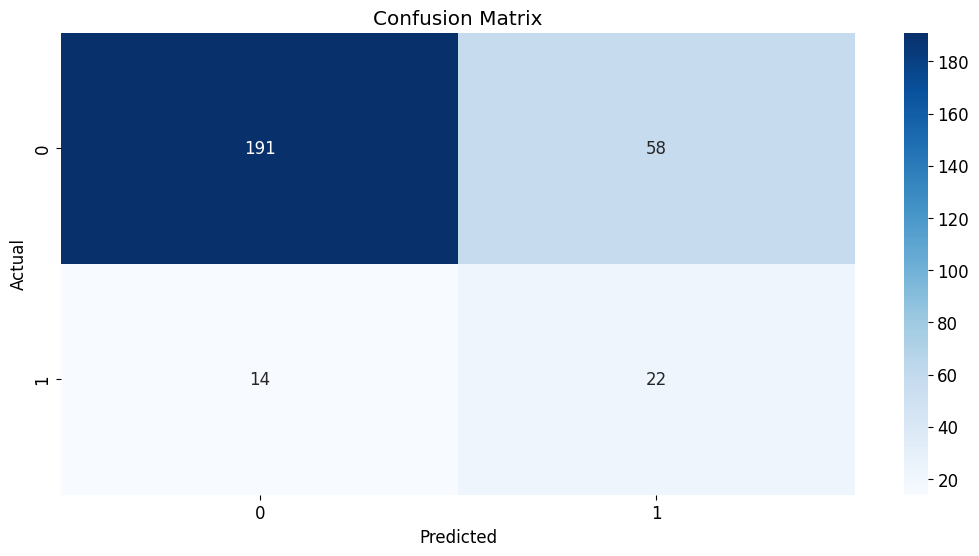

Avg AUC for Random Forest: 0.6549531459170014
Avg f-score for Random Forest: 0.7340638105377497
Avg f-score for Random Forest defaulted: 0.3363237639553429
Avg f-score for Random Forest paid: 0.7915683955858087
Avg f-score for Random Forest paid: 0.7915683955858087
Negative Predictive Value: 0.925531914893617
False Positive Rate: 0.30120481927710846


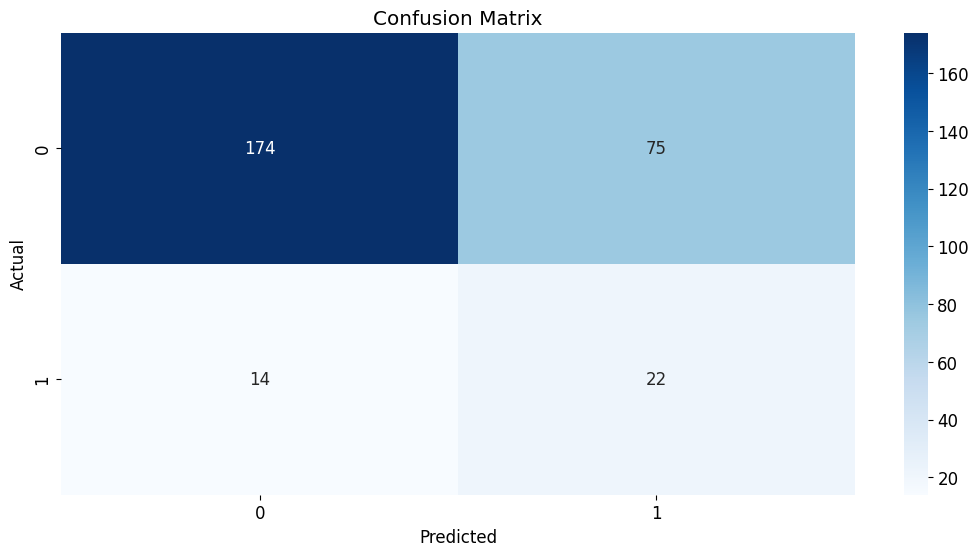

Avg AUC for SVM: 0.7136880856760376
Avg f-score for SVM: 0.6611744566302189
Avg f-score for SVM defaulted: 0.3660334863165051
Avg f-score for SVM paid: 0.7038454402900328
Avg f-score for SVM paid: 0.7038454402900328
Negative Predictive Value: 0.9657534246575342
False Positive Rate: 0.43373493975903615


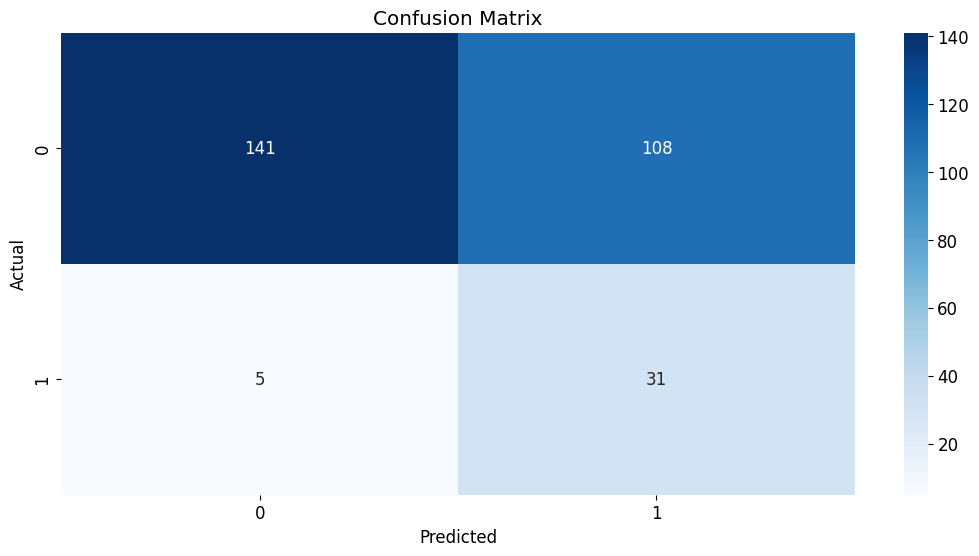

Avg AUC for Naive Bayes: 0.7269076305220884
Avg f-score for Naive Bayes: 0.58817173158643
Avg f-score for Naive Bayes defaulted: 0.34712706017053846
Avg f-score for Naive Bayes paid: 0.6230215635983661
Avg f-score for Naive Bayes paid: 0.6230215635983661
Negative Predictive Value: 1.0
False Positive Rate: 0.5461847389558233


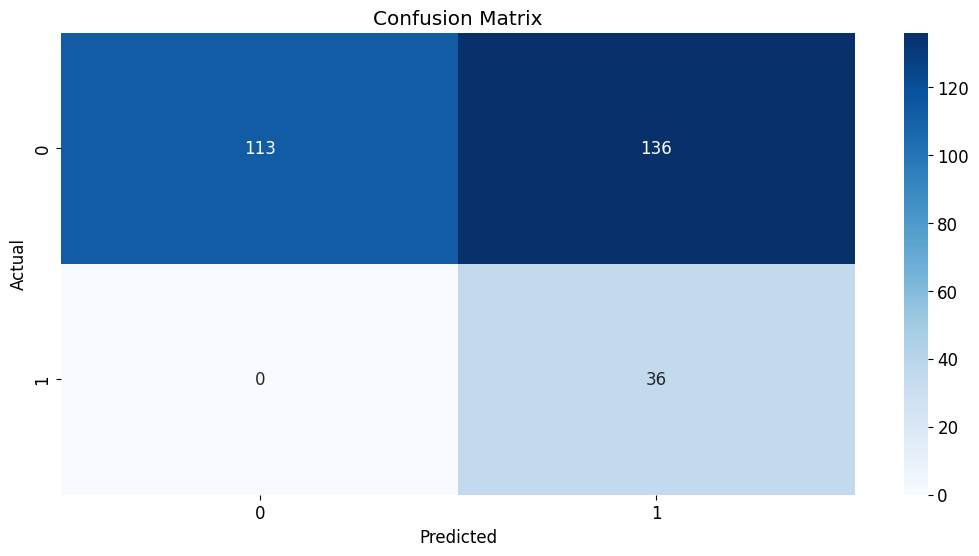

In [ ]:
cvu_lg_f1, cvu_lg_f1_pos, cvu_lg_f1_neg = crossval(LogisticRegression(), "Logistic Regression", 3, RandomUnderSampler())
cvu_rfg_f1, cvu_rfg_f1_pos, cvu_rfg_f1_neg = crossval(RandomForestClassifier(), "Random Forest", 3, RandomUnderSampler())
cvu_svm_f1, cvu_svm_f1_pos, cvu_svm_f1_neg = crossval(SVC(), "SVM", 3, RandomUnderSampler())
cvu_nb_f1, cvu_nb_f1_pos, cvu_nb_f1_neg = crossval(GaussianNB(), "Naive Bayes", 3, RandomUnderSampler())

As expected, f1 score increases for the smaller class, at the cost of the whole model.

#### Smote

Avg AUC for Logistic Regression: 0.5967202141900937
Avg f-score for Logistic Regression: 0.8281112137067815
Avg f-score for Logistic Regression defaulted: 0.2850877192982456
Avg f-score for Logistic Regression paid: 0.9066206345851241
Avg f-score for Logistic Regression paid: 0.9066206345851241
Negative Predictive Value: 0.8976377952755905
False Positive Rate: 0.08433734939759036


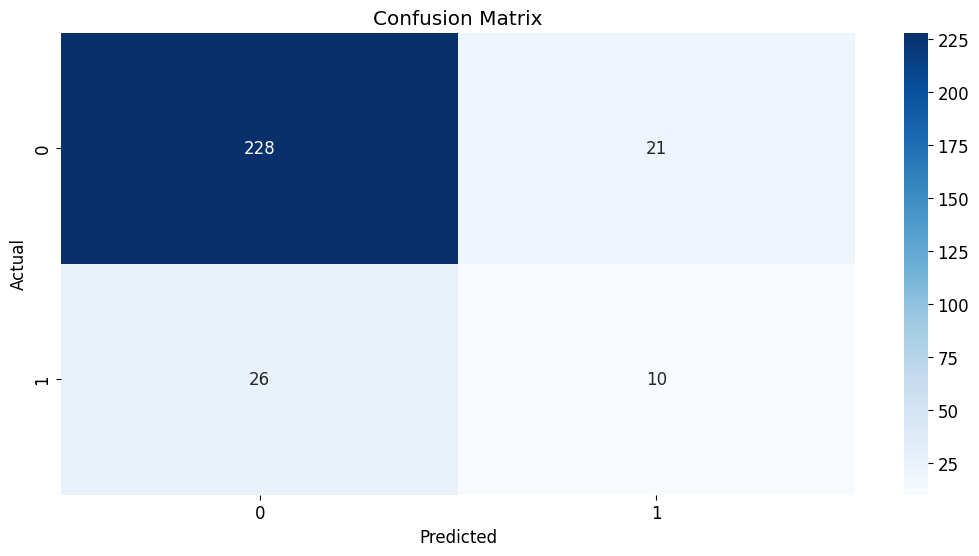

Avg AUC for Random Forest: 0.5891900937081661
Avg f-score for Random Forest: 0.8559521469364072
Avg f-score for Random Forest defaulted: 0.296218487394958
Avg f-score for Random Forest paid: 0.9368774953038458
Avg f-score for Random Forest paid: 0.9368774953038458
Negative Predictive Value: 0.8941605839416058
False Positive Rate: 0.01606425702811245


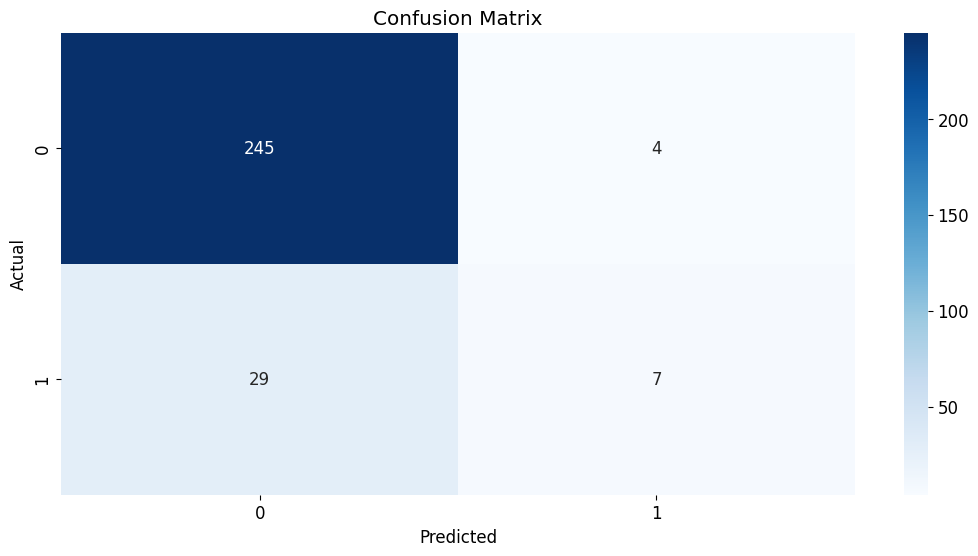

Avg AUC for SVM: 0.5475234270414994
Avg f-score for SVM: 0.8349960937438285
Avg f-score for SVM defaulted: 0.16732026143790849
Avg f-score for SVM paid: 0.9315275393784194
Avg f-score for SVM paid: 0.9315275393784194
Negative Predictive Value: 0.8844765342960289
False Positive Rate: 0.01606425702811245


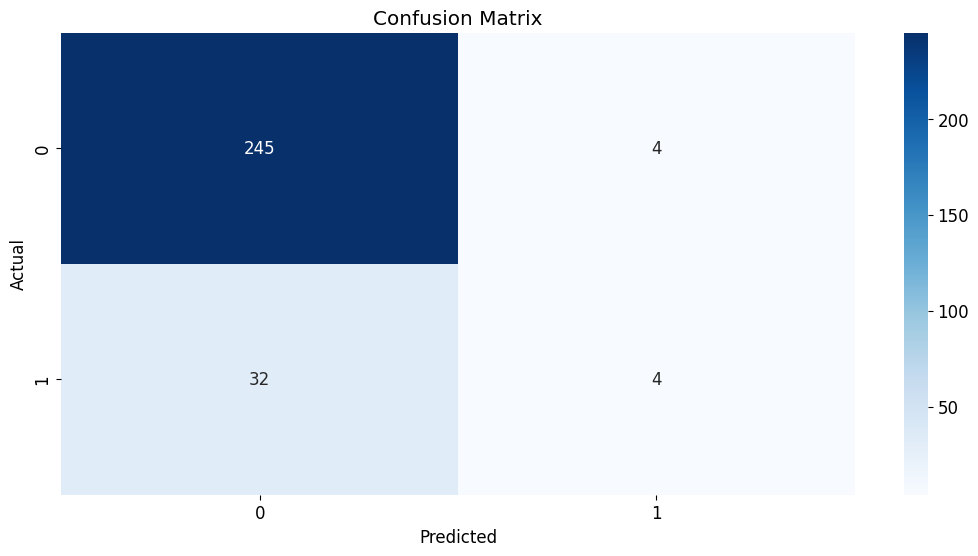

Avg AUC for Naive Bayes: 0.7357764390896921
Avg f-score for Naive Bayes: 0.6983677905637978
Avg f-score for Naive Bayes defaulted: 0.3740421455938698
Avg f-score for Naive Bayes paid: 0.7452582452582454
Avg f-score for Naive Bayes paid: 0.7452582452582454
Negative Predictive Value: 0.9681528662420382
False Positive Rate: 0.3895582329317269


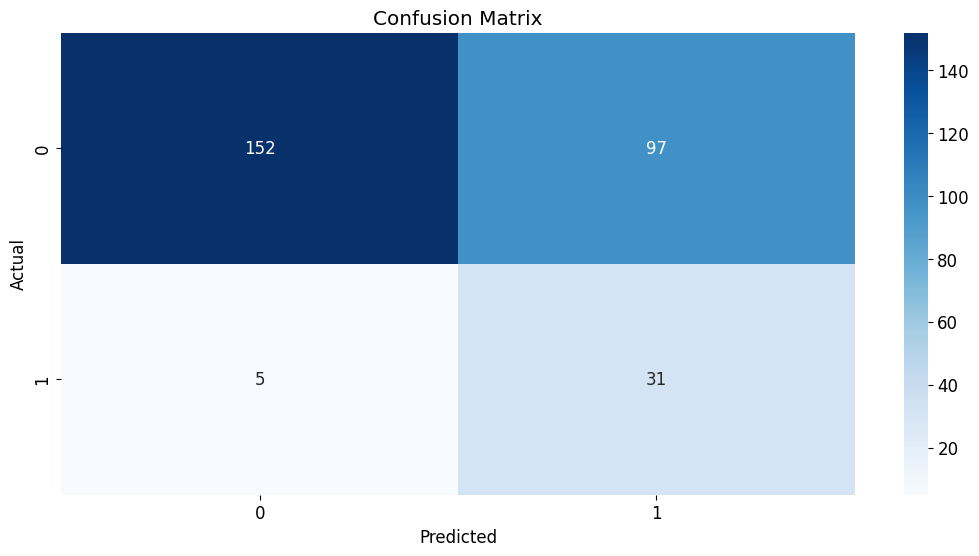

In [ ]:
cvs_lg_f1, cvs_lg_f1_pos, cvs_lg_f1_neg = crossval(LogisticRegression(), "Logistic Regression", 3, SMOTENC(categorical_features=categorical_indexes))
cvs_rfg_f1, cvs_rfg_f1_pos, cvs_rfg_f1_neg = crossval(RandomForestClassifier(), "Random Forest", 3, SMOTENC(categorical_features=categorical_indexes))
cvs_svm_f1, cvs_svm_f1_pos, cvs_svm_f1_neg = crossval(SVC(), "SVM", 3, SMOTENC(categorical_features=categorical_indexes))
cvs_nb_f1, cvs_nb_f1_pos, cvs_nb_f1_neg = crossval(GaussianNB(), "Naive Bayes", 3, SMOTENC(categorical_features=categorical_indexes))

#### K-Fold Graphs

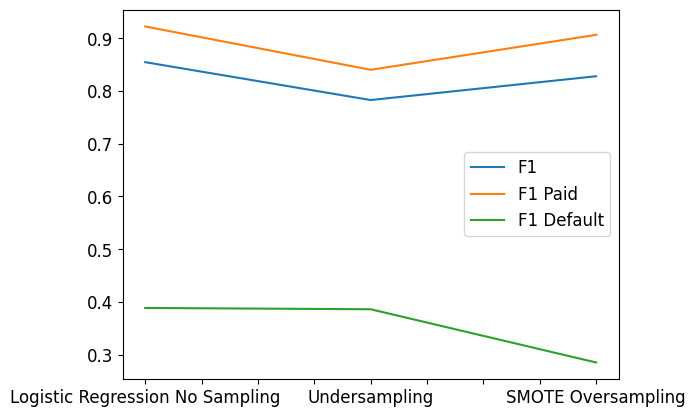

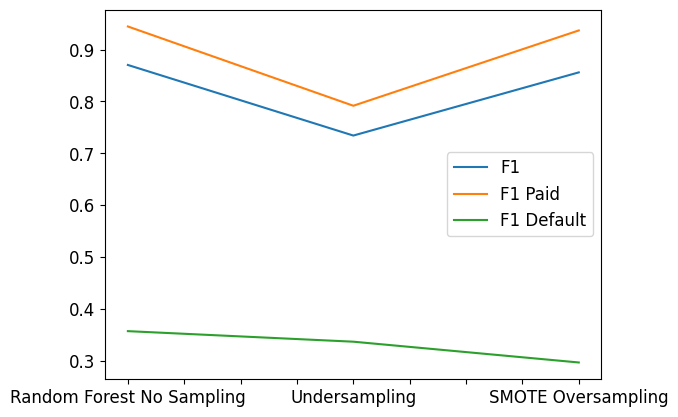

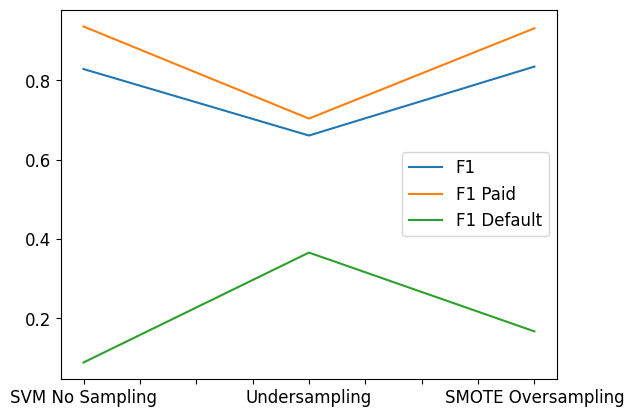

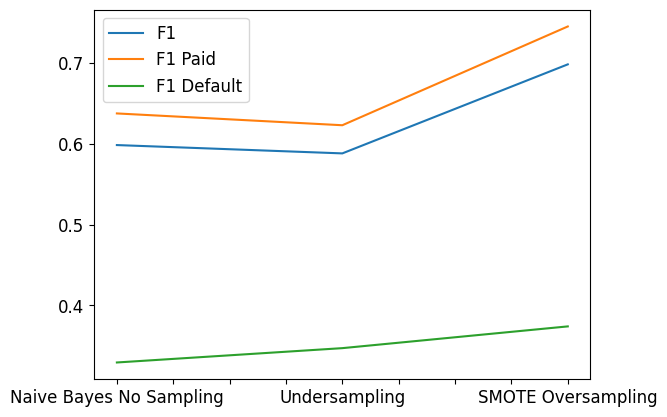

In [ ]:
lg = pd.DataFrame({
   'F1': [cv_lg_f1, cvu_lg_f1, cvs_lg_f1],
   'F1 Paid': [cv_lg_f1_neg, cvu_lg_f1_neg, cvs_lg_f1_neg],
   'F1 Default': [cv_lg_f1_pos, cvu_lg_f1_pos, cvs_lg_f1_pos],
   }, index=['Logistic Regression No Sampling', 'Undersampling', 'SMOTE Oversampling'])

lines = lg.plot()

rfg = pd.DataFrame({
   'F1': [cv_rfg_f1, cvu_rfg_f1, cvs_rfg_f1],
   'F1 Paid': [cv_rfg_f1_neg, cvu_rfg_f1_neg, cvs_rfg_f1_neg],
   'F1 Default': [cv_rfg_f1_pos, cvu_rfg_f1_pos, cvs_rfg_f1_pos],
   }, index=['Random Forest No Sampling', 'Undersampling', 'SMOTE Oversampling'])

lines = rfg.plot()

svm = pd.DataFrame({
   'F1': [cv_svm_f1, cvu_svm_f1, cvs_svm_f1],
   'F1 Paid': [cv_svm_f1_neg, cvu_svm_f1_neg, cvs_svm_f1_neg],
   'F1 Default': [cv_svm_f1_pos, cvu_svm_f1_pos, cvs_svm_f1_pos],
   }, index=['SVM No Sampling', 'Undersampling', 'SMOTE Oversampling'])

lines = svm.plot()

nb = pd.DataFrame({
   'F1': [cv_nb_f1, cvu_nb_f1, cvs_nb_f1],
   'F1 Paid': [cv_nb_f1_neg, cvu_nb_f1_neg, cvs_nb_f1_neg],
   'F1 Default': [cv_nb_f1_pos, cvu_nb_f1_pos, cvs_nb_f1_pos],
   }, index=['Naive Bayes No Sampling', 'Undersampling', 'SMOTE Oversampling'])

lines = nb.plot()

### Hypertuning and Feature Selection

For our final improvement, we decided to integrate hypertuning and feature selection in the pipeline, while targetting roc_auc.
We tested only Logistic Regression, Random Forest and SVM as Naive Bayes proved to be significantly worse than those 3.

In [ ]:
def hypertuned_plots(search):
    x_train,x_test,y_train,y_test=train_test_split(data_without_labels,labels,train_size=0.66)
    pipe = search.best_estimator_
    pipe.fit(x_train, y_train)
    predictions = pipe.predict(x_test)
    plot_confusion_matrix(y_test,predictions)
    curve(pipe, x_test, y_test)

In [ ]:
def hypertuneModel(model, params, feature_estimator):
    pipeline = Pipeline([("scaler", StandardScaler()),("sampling", SMOTETomek()),('feature_selection', SelectFromModel(estimator=feature_estimator)), ("classification", model)])
    kf = StratifiedKFold(n_splits=5, shuffle =True)
    clf= RandomizedSearchCV(pipeline, params, cv=kf, scoring='roc_auc', refit=True) 
    search = clf.fit(data_without_labels, labels)
    print("\n The best score across ALL searched params:\n", search.best_score_)
    print("\n The best parameters across ALL searched params:\n", search.best_params_)
    print("\n Standard Deviation: ", search.cv_results_['std_test_score'][search.best_index_])

    hypertuned_plots(search)
    return search.best_estimator_, search.best_score_

#### Random Forest

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor


 The best score across ALL searched params:
 0.8506734693877551

 The best parameters across ALL searched params:
 {'sampling__smote': SMOTENC(categorical_features=[6, 23, 37]), 'classification__n_estimators': 1800, 'classification__min_samples_split': 5, 'classification__min_samples_leaf': 1, 'classification__max_features': 'auto', 'classification__max_depth': 20, 'classification__bootstrap': True}

 Standard Deviation:  0.03962294170516745


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Negative Predictive Value: 0.9310344827586207
False Positive Rate: 0.07954545454545454


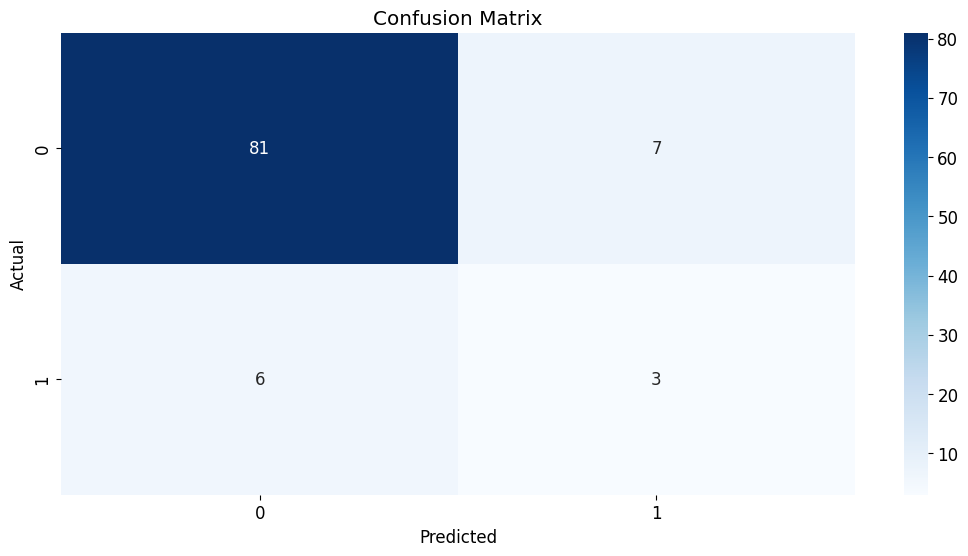

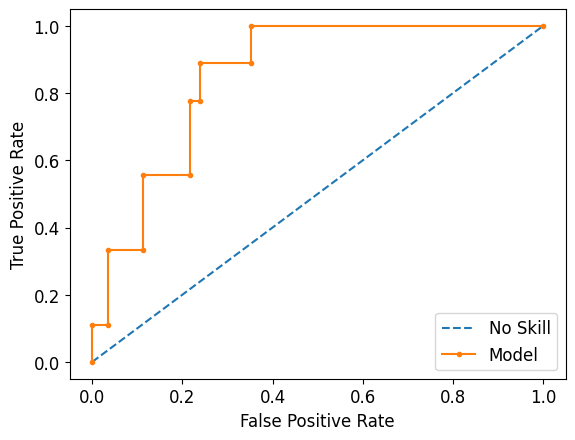

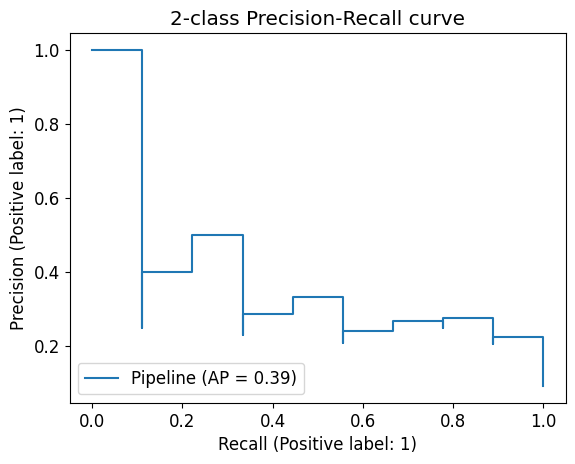

In [ ]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'classification__n_estimators': n_estimators,
               'classification__max_features': max_features,
               'classification__max_depth': max_depth,
               'classification__min_samples_split': min_samples_split,
               'classification__min_samples_leaf': min_samples_leaf,
               'classification__bootstrap': bootstrap,
               'sampling__smote': [SMOTENC(categorical_features=categorical_indexes, k_neighbors=int(x)) for x in np.linspace(1, 20, num = 10)]}

rfg, rfg_score = hypertuneModel(RandomForestClassifier(), random_grid, RandomForestClassifier())

#### Logistic Regression

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c


 The best score across ALL searched params:
 0.8615102040816327

 The best parameters across ALL searched params:
 {'sampling__smote': SMOTENC(categorical_features=[6, 23, 37], k_neighbors=17), 'classification__solver': 'lbfgs', 'classification__penalty': 'l2', 'classification__C': 0.1}

 Standard Deviation:  0.04746915963235061
Negative Predictive Value: 0.9333333333333333
False Positive Rate: 0.20454545454545456


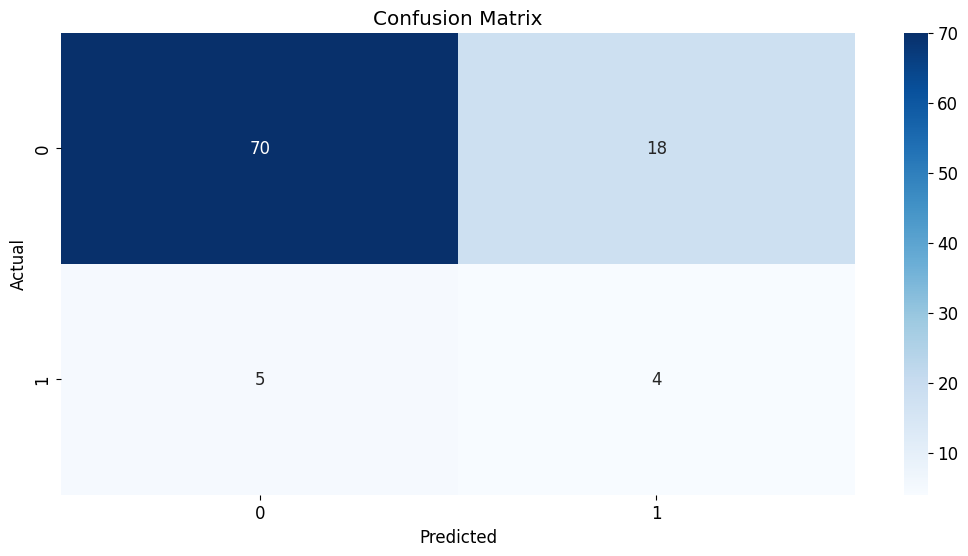

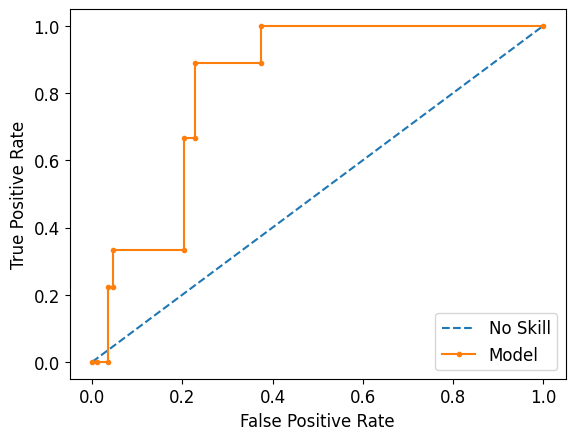

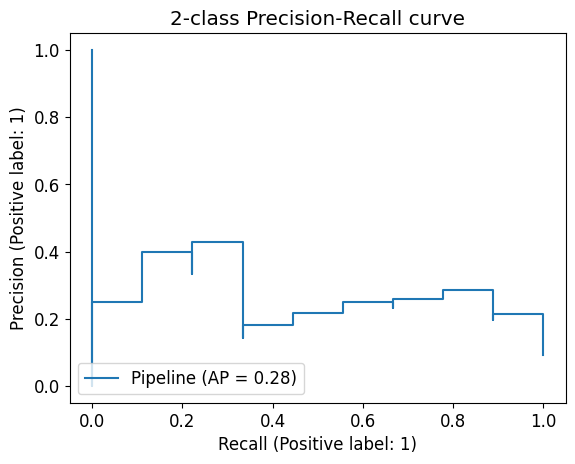

In [ ]:
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
random_grid = {
    'classification__solver': solvers,
    'classification__penalty': penalty,
    'classification__C': c_values,
    'sampling__smote': [SMOTENC(categorical_features=categorical_indexes, k_neighbors=int(x)) for x in np.linspace(1, 20, num = 10)]
}

logreg, logreg_score = hypertuneModel(LogisticRegression(), random_grid, LogisticRegression())

#### SVM

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w


 The best score across ALL searched params:
 0.8935510204081633

 The best parameters across ALL searched params:
 {'sampling__smote': SMOTENC(categorical_features=[6, 23, 37], k_neighbors=7), 'classification__kernel': 'sigmoid', 'classification__gamma': 0.0001, 'classification__class_weight': 'balanced', 'classification__C': 1000}

 Standard Deviation:  0.025035285386210665


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Negative Predictive Value: 0.9146341463414634
False Positive Rate: 0.0963855421686747


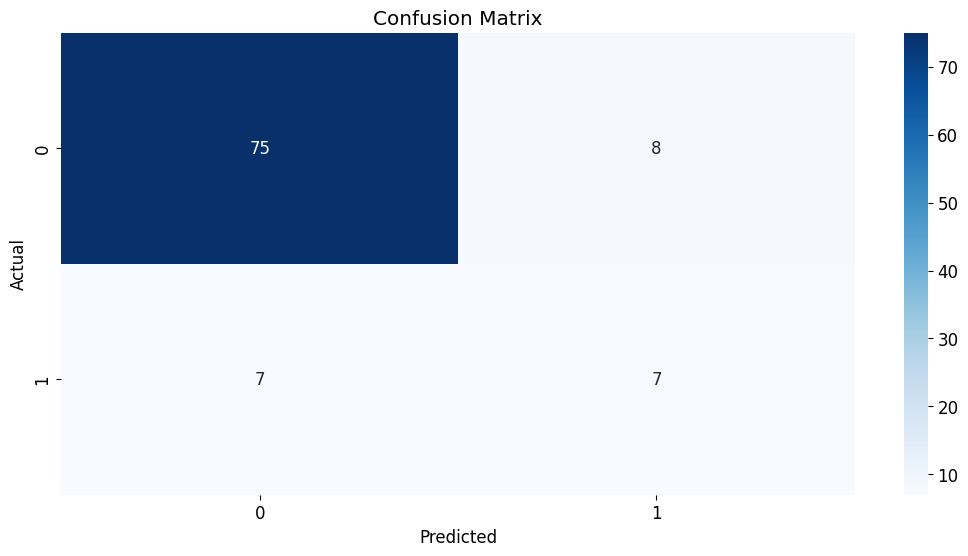

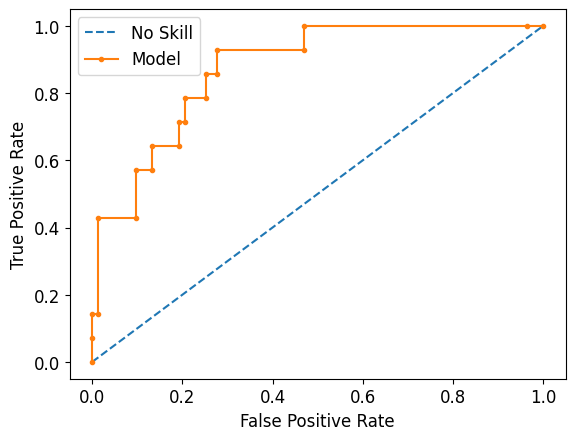

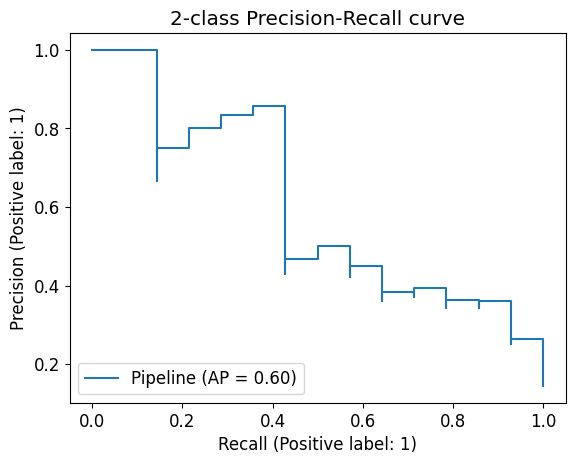

In [ ]:
random_grid = {'classification__C': [0.1,1, 10, 100, 1000],
            'classification__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
            'classification__kernel': ['rbf', 'poly', 'sigmoid'],
            'classification__class_weight':['balanced', 'None'],
            'sampling__smote': [SMOTENC(categorical_features=categorical_indexes, k_neighbors=int(x)) for x in np.linspace(1, 20, num = 10)]}
svm, svm_score = hypertuneModel(SVC(probability=True), random_grid, LinearSVC('l1', dual=False))

## Competition Data Treatment and Prediction Export

In [ ]:
loans, transactions, accounts, dispositions, clients, cards, districts = loaddata(False)
cards, transactions, loans, clients = date_treatment(cards, transactions, loans, client_agesex(disp_merge(dispositions, accounts, clients)))
clients = card_client_merge(cards, clients)
districts = clean_districts(districts)
clients = add_trans_to_client(transaction_extraction(transactions), clients)
loans = final_loan_merge(loans, clients, districts)
loans, categorical_indexes = category_treatment(loans)
loans

[nan 'interest credited' ' ' 'insurrance payment' 'household'
 'payment for statement' 'sanction interest if negative balance']


,loan_id,amount,duration,payments,status,frequency,num_clients,sex,has_card,num_salaries,...,cities_branch,urbanization_branch,avg_salary_branch,unemployment96_branch,entrepreneurs/1000_branch,crimerate96_branch,crimegrowth_branch,unempgrowth_branch,age_when_loan,account_age_when_loan
0,5895,93960,60,1566,NaN,0,1,0,0,14.0,...,5,53.5,8390,2.89,132,0.027234,1.020192,1.267544,34.592745,1.237509
1,5172,50976,36,1416,NaN,0,1,0,0,16.0,...,5,53.5,8390,2.89,132,0.027234,1.020192,1.267544,18.469541,1.357974
2,6207,184620,60,3077,NaN,0,1,1,0,19.0,...,5,53.5,8390,2.89,132,0.027234,1.020192,1.267544,34.767967,1.659138
3,7122,260640,36,7240,NaN,0,1,1,0,16.0,...,6,52.4,8620,1.25,100,0.019127,1.025712,1.136364,47.953457,1.341547
4,7067,136368,24,5682,NaN,0,1,0,0,8.0,...,6,52.4,8620,1.25,100,0.019127,1.025712,1.136364,28.522930,0.711841
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349,7294,39168,24,1632,NaN,0,1,1,0,11.0,...,6,63.4,9920,2.87,130,0.051159,1.129867,1.269912,19.594798,0.950034
350,6321,38496,12,3208,NaN,0,1,1,1,12.0,...,6,63.4,9920,2.87,130,0.051159,1.129867,1.269912,34.688569,1.067762
351,6469,99744,24,4156,NaN,2,1,1,0,17.0,...,6,63.4,9920,2.87,130,0.051159,1.129867,1.269912,27.222450,1.431896
352,5614,253560,60,4226,NaN,0,1,1,0,21.0,...,4,89.9,10446,9.40,90,0.039560,0.958763,1.280654,47.255305,1.765914


Rather than running columns dropping functions again we can just drop every column not in the training data.

In [ ]:
new_data = loans
new_data.drop(columns=[col for col in new_data if col not in data_without_labels.columns.values], inplace=True)
new_data.head()

,loan_id,amount,duration,payments,num_clients,sex,has_card,num_salaries,average_balance_fluctuation_per_month,recent_balance,...,munip>10000_branch,cities_branch,urbanization_branch,avg_salary_branch,unemployment96_branch,entrepreneurs/1000_branch,crimerate96_branch,crimegrowth_branch,unempgrowth_branch,age_when_loan
0,5895,93960,60,1566,1,0,0,14.0,1737.392857,49548.5,...,1,5,53.5,8390,2.89,132,0.027234,1.020192,1.267544,34.592745
1,5172,50976,36,1416,1,0,0,16.0,220.318750,21313.1,...,1,5,53.5,8390,2.89,132,0.027234,1.020192,1.267544,18.469541
2,6207,184620,60,3077,1,1,0,19.0,1024.336842,39023.4,...,1,5,53.5,8390,2.89,132,0.027234,1.020192,1.267544,34.767967
3,7122,260640,36,7240,1,1,0,16.0,660.337500,11565.4,...,1,6,52.4,8620,1.25,100,0.019127,1.025712,1.136364,47.953457
4,7067,136368,24,5682,1,0,0,8.0,-1203.500000,51899.0,...,1,6,52.4,8620,1.25,100,0.019127,1.025712,1.136364,28.522930


Get the best estimator from AUC value and use it.

In [ ]:
estimator = None
if(rfg_score > svm_score and rfg_score > logreg_score):
    estimator = rfg
    print("Picked RF")
if(logreg_score > svm_score and logreg_score > rfg_score):
    estimator = logreg
    print("Picked LR")
if(svm_score > rfg_score and svm_score > logreg_score):
    estimator = svm
    print("Picked SVM")

Picked SVM


In [ ]:
mod_probs = estimator.predict_proba(new_data)
neg_prob = []
for prob in mod_probs:
    neg_prob.append(prob[1])
ids = loans['loan_id'].tolist()
d = {'Id': ids, 'Predicted': neg_prob}
final = pd.DataFrame(data=d)
final.to_csv('pred.csv', index=False)

## Plotting - Data Understanding

In [ ]:
loans = pd.read_csv("./data/loan_dev.csv", sep=";",dtype=int)
transactions = pd.read_csv("./data/trans_dev.csv", sep=";",dtype={"trans_id":int,"account_id":int,"date":int,"type":str,"operation":str,"amount":float,"balance":float,"k_symbol":str,"bank":str,"account":str})
accounts = pd.read_csv("./data/account.csv", sep=";",dtype={"account_id":int,"district_id":int,"frequency":str,"date":int})
cards = pd.read_csv("./data/card_dev.csv", sep=";",dtype={"card_id":int,"disp_id":int,"type":str,"issued":int})
clients = pd.read_csv("./data/client.csv", sep=";",dtype=int)
dispositions = pd.read_csv("./data/disp.csv", sep=";",dtype={"disp_id":int,"client_id":int,"account_id":int,"type":str})
districts = pd.read_csv("./data/district.csv", na_values=['?'], sep=";",dtype={"code":int, "name":str, "region":str,"no. of inhabitants":int,"no. of municipalities with inhabitants < 499":int,"no. of municipalities with inhabitants 500-1999":int,"no. of municipalities with inhabitants 2000-9999":int, "no. of municipalities with inhabitants >10000": int, "no. of cities":int, "ratio of urban inhabitants":float, "average salary":float, "unemploymant rate '95":float, "unemploymant rate '96":float, "no. of enterpreneurs per 1000 inhabitants": float, "no. of commited crimes '95":int, "no. of commited crimes '96":int})
final_dataset = pd.read_csv("./data/merged_dataset.csv", na_values=['?'], sep=',', dtype={"age":int})

In [ ]:


def accounts_plot():

        accounts_with_loans = len(loans["account_id"].unique())
        unique_accounts = len(accounts["account_id"].unique())

        sizes = [accounts_with_loans, unique_accounts]

        labels = ["Accounts with loans", "Accounts without\nloans"]

        fig1, ax1 = plt.subplots()
        ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
                shadow=True, startangle=30)
        ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
        plt.title("Ratio of accounts with loans to accounts without loans")
        plt.savefig('plots/accounts_with_loans.png', transparent=True)


def card_plot():

        cards_disp = pd.merge(cards, dispositions, on="disp_id")
        num_accounts_without_card =  len(accounts["account_id"].unique())  - len(cards_disp["account_id"].unique())
        num_accounts_junior = len(cards_disp[cards_disp["type_x"] == "junior"]["account_id"].unique())
        num_accounts_classic = len(cards_disp[cards_disp["type_x"] == "classic"]["account_id"].unique())
        num_accounts_gold = len(cards_disp[cards_disp["type_x"] == "gold"]["account_id"].unique())

        sizes = [num_accounts_without_card, num_accounts_classic, num_accounts_junior, num_accounts_gold]
        labels = ["None", "Classic", "Junior", "Gold"]


        name = labels
        price = sizes
        
        # Figure Size
        fig, ax = plt.subplots(figsize =(16, 9))
        
        # Horizontal Bar Plot
        ax.barh(name, price)
        
        # Remove axes splines
        for s in ['top', 'bottom', 'left', 'right']:
                ax.spines[s].set_visible(False)
        
        # Remove x, y Ticks
        ax.xaxis.set_ticks_position('none')
        ax.yaxis.set_ticks_position('none')
        
        # Add padding between axes and labels
        ax.xaxis.set_tick_params(pad = 5)
        ax.yaxis.set_tick_params(pad = 10)
        
        # Add x, y gridlines
        ax.grid(b = True, color ='grey',
                linestyle ='-.', linewidth = 0.5,
                alpha = 0.2)
        
        # Show top values
        ax.invert_yaxis()
        
        # Add annotation to bars
        for i in ax.patches:
                plt.text(i.get_width()+0.2, i.get_y()+0.4,
                        str(round((i.get_width()), 2)),
                        fontsize = 10, fontweight ='bold',
                        color ='grey')
        
        # Add Plot Title
        ax.set_title('Number of accounts with specific card types')
        
        # Show Plot
        plt.savefig('plots/card_types_bar.png', transparent=True)


def plot_loans():

        num_nonpayed_loans = len(loans[loans["status"] == -1]["loan_id"].unique())
        num_payed_loans = len(loans[loans["status"] == 1]["loan_id"].unique())
        sizes = [num_payed_loans, num_nonpayed_loans]
        labels = ["1", "-1"]

        name = labels
        price = sizes
        
        # Figure Size
        fig, ax = plt.subplots(figsize =(11, 6))
        
        # Horizontal Bar Plot
        ax.barh(name, price)
        
        # Remove axes splines
        for s in ['top', 'bottom', 'left', 'right']:
                ax.spines[s].set_visible(False)
        
        # Remove x, y Ticks
        ax.xaxis.set_ticks_position('none')
        ax.yaxis.set_ticks_position('none')
        
        # Add padding between axes and labels
        ax.xaxis.set_tick_params(pad = 5)
        ax.yaxis.set_tick_params(pad = 10)
        
        # Add x, y gridlines
        ax.grid(b = True, color ='grey',
                linestyle ='-.', linewidth = 0.5,
                alpha = 0.2)
        
        # Show top values
        ax.invert_yaxis()
        
        # Add annotation to bars
        for i in ax.patches:
                plt.text(i.get_width()+0.2, i.get_y()+0.4,
                        str(round((i.get_width()), 2)),
                        fontsize = 10, fontweight ='bold',
                        color ='grey')
        
        # Add Plot Title
        ax.set_title('Loan Type Distribution')
        
        
        # Show Plot
        plt.savefig('plots/loan_types_bar.png', transparent=True)


        
 
        nonpayed_loan_amount = loans[loans["status"] == -1]["amount"]
        payed_loan_amount = loans[loans["status"] == 1]["amount"]

        data = [nonpayed_loan_amount, payed_loan_amount]
        
        fig, ax = plt.subplots(figsize =(11, 6))
        
        
        # Creating plot
        bp = ax.boxplot(x=data, labels=["-1", "1"])

        plt.ylabel("Amount (czech crowns)")

        plt.title("Loan amount distribution")

        
        # show plot
        plt.savefig('plots/loan_amount_boxplot.png', transparent=True)


        durations = loans["duration"]
        amounts = loans["amount"]

        fig, ax = plt.subplots(figsize =(16, 9))

        plt.scatter(durations, amounts)
        plt.xlabel("Duration (months)") 
        plt.ylabel("Amount (czech crowns)")
        plt.title("Relation between loan amount and duration")

        plt.savefig('plots/loan_amount_duration_scatter.png', transparent=True)


        payments = loans["payments"]

        fig, ax = plt.subplots(figsize =(16, 9))

        sc = plt.scatter(payments, amounts, c=durations)
        plt.xlabel("Payments (czech crowns)")
        plt.ylabel("Amount (czech crowns)")
        cb = fig.colorbar(sc, ax=ax, label='Duration (months)')

        plt.title("Relation between loan amount, payments and duration")

        plt.savefig('plots/loan_amount_payments_duration_scatter.png', transparent=True)

        fig, ax = plt.subplots(figsize =(16, 9))

        # pplot(iris, x="sepal_length", y=gamma, hue="species", kind='qq', height=4, aspect=2)


        fig, ax = plt.subplots(figsize =(16, 9))
        fig = sm.qqplot(nonpayed_loan_amount, stats.t, fit=True, line="s")
        plt.title("Unpayed loan amount distribution")
        plt.savefig('plots/loan_amount_nonpayed_qqplot.png', transparent=True)

        fig, ax = plt.subplots(figsize =(16, 9))
        fig = sm.qqplot(payed_loan_amount, stats.t, fit=True, line="s")
        plt.title("Payed loan amount distribution")
        plt.savefig('plots/loan_amount_payed_qqplot.png', transparent=True)




def plot_transactions():

        loans_accountid = loans["account_id"].unique()
        transactions_in_loans = transactions[transactions["account_id"].isin(loans_accountid)]

        transactions_to_plot = transactions_in_loans

        balances = [x for x in range(0, 190001, 5000)]
        amounts = [x for x in range(0, 90001,2500)]

        amount = transactions_to_plot["amount"]
        balance = transactions_to_plot["balance"]
        frequency = []

        balance_rebalance = list(map(lambda x: balances[int(x//5000)], balance))
        amount_rebalance = list(map(lambda x: amounts[int(x//2500)], amount))

        amount = amount_rebalance
        balance = balance_rebalance


        points = list(zip(amount, balance))

        points_dict = {}
        for point in points:
                if point in points_dict:
                        points_dict[point] += 1
                else:
                        points_dict[point] = 1
        
        for point in points:
                frequency.append(points_dict[point])


        fig, ax = plt.subplots(figsize =(16, 9))


        

        hb = plt.hexbin(x=amount, y=balance, C=frequency, gridsize=(30, 15), cmap="Reds", bins="log")
        cb = fig.colorbar(hb, ax=ax, label='Frequency')

        plt.title("Transaction amount related to balance")
        plt.xlabel("Amount")
        plt.ylabel("Balance")
        plt.savefig('plots/transaction_amount_balance.png', transparent=True)


def plot_districts():
        #nº habitants, urban ratio and average salary
        salary = districts["average salary "]
        habitants = districts["no. of inhabitants"]
        urban_ratio = districts["ratio of urban inhabitants "]
        num_enterporneurs = districts["no. of enterpreneurs per 1000 inhabitants "]
        unemployment_95 = districts["unemploymant rate '95 "]
        unemployment_96 = districts["unemploymant rate '96 "]
        num_crimes_95 = districts["no. of commited crimes '95 "]
        num_crimes_96 = districts["no. of commited crimes '96 "]
        avg_unemployment = (unemployment_95 + unemployment_96) / 2
        avg_num_crimes = (num_crimes_95 + num_crimes_96) / 2
        

        fig, ax = plt.subplots(figsize =(16, 9))
        sc = plt.scatter(habitants, urban_ratio, c=salary)
        plt.xlabel("Nº habitants")
        plt.ylabel("Ratio of Urban Inhabitants")
        cb = fig.colorbar(sc, ax=ax, label='Average Salary')
        plt.title("Relation between salary, habitants and urban ratio")
        plt.savefig('plots/salary_habitants_urbanratio_scatter.png', transparent=True)

        fig, ax = plt.subplots(figsize =(16, 9))
        sc = plt.scatter(habitants, num_enterporneurs, c=salary)
        plt.xlabel("Nº habitants")
        plt.ylabel("Nº enterpreneurs per 1000 habitants")
        cb = fig.colorbar(sc, ax=ax, label='Average salary')
        plt.title("Relation between salary, habitants and number of enterpreneurs")
        plt.savefig('plots/salary_habitants_enterpreneurs_scatter.png', transparent=True)

        fig, ax = plt.subplots(figsize =(16, 9))
        sc = plt.scatter(habitants, avg_unemployment, c=salary)
        plt.xlabel("Nº habitants")
        plt.ylabel("Averega Unemployment Rate in '95 and '96")
        cb = fig.colorbar(sc, ax=ax, label='Average salary')
        plt.title("Relation between salary, habitants and Averega Unemployment Rate")
        plt.savefig('plots/salary_habitants_unemployment_scatter.png', transparent=True)

        fig, ax = plt.subplots(figsize =(16, 9))
        sc = plt.scatter(habitants, avg_num_crimes, c=salary)
        plt.xlabel("Nº habitants")
        plt.ylabel("Averega number of crimes in '95 and '96")
        cb = fig.colorbar(sc, ax=ax, label='Average salary')
        plt.title("Relation between salary, habitants and Average number of crimes")
        plt.savefig('plots/salary_habitants_crime_scatter.png', transparent=True)


        fig = plt.figure(figsize =(16, 9))
        ax =plt.axes(projection ="3d")
        sc = ax.scatter3D(habitants, urban_ratio, num_enterporneurs, c=salary)
        plt.xlabel("Nº habitants")
        plt.ylabel("Ratio of Urban Inhabitants")
        ax.set_zlabel("Nº enterpreneurs per 1000 habitants")
        cb = fig.colorbar(sc, ax=ax, label='Average Salary')
        plt.title("Relation between salary, habitants, urban ratio and number of enterpreneurs")
        plt.savefig('plots/salary_habitants_urbanratio_enterpreneurs_scatter.png', transparent=True)


def plot_final_dataset():
        # importing diamond dataset from the library
        fig, ax = plt.subplots(figsize =(15, 10))
        # plotting histogram for carat using distplot()
        sns.displot(final_dataset["age_when_loan"], kde=True, bins=20, kde_kws=dict(cut=3))


        plt.savefig('plots/age_of_loan_displot.png', transparent=True)


        #avg salary and recent balance
        figure, axis = plt.subplots(nrows=2, ncols=2, figsize=(16, 11))
        axis[0][0].hist(final_dataset["average_balance_fluctuation_per_month"], bins=20, )
        axis[0][0].set_title("Balance variation per month frequency")
        axis[0][1].boxplot(final_dataset["average_balance_fluctuation_per_month"], labels=[""])
        axis[0][1].set_title("Balance variation per month Boxplot")
        axis[1][0].hist(final_dataset["recent_balance"], bins=20, )
        axis[1][0].set_title("Recent Balance Frequency")
        axis[1][1].boxplot(final_dataset["recent_balance"], labels=[""])
        axis[1][1].set_title("Recent Balance Boxplot")
        plt.savefig('plots/balanceVariation_balance_distributions.png', transparent=True)

        #salary and balance by sex

        males = final_dataset[final_dataset["sex"] == 1]
        females = final_dataset[final_dataset["sex"] == 0]

        fig, ax = plt.subplots(figsize =(16, 9))

        ax.scatter(males["average_balance_fluctuation_per_month"], males["recent_balance"], s=10, c="blue", marker="s", label="males")
        ax.scatter(females["average_balance_fluctuation_per_month"], females["recent_balance"], s=10, c="red", marker="o", label="females")
        
        b_male, a_male = np.polyfit(males["average_balance_fluctuation_per_month"], males["recent_balance"], deg=1)
        b_female, a_female = np.polyfit(females["average_balance_fluctuation_per_month"], females["recent_balance"], deg=1)
        xseq = np.linspace(0, 10, num=100)

        ax.plot(xseq, a_male + b_male * xseq, color="blue", lw=2.5)
        ax.plot(xseq, a_female + b_female * xseq, color="red", lw=2.5)

        
        plt.xlabel("Average Balance Fluctuation per month")
        plt.ylabel("Recent balance")
        plt.legend(loc="upper right")
        plt.title("Balance Variantion and Total Balance for men and women")
        plt.savefig('plots/BalanceVariation_balance_sex_scatter.png', transparent=True)


/tmp/ipykernel_138687/2917541526.py:52: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',
/tmp/ipykernel_138687/2917541526.py:102: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


NameError: name 'sm' is not defined

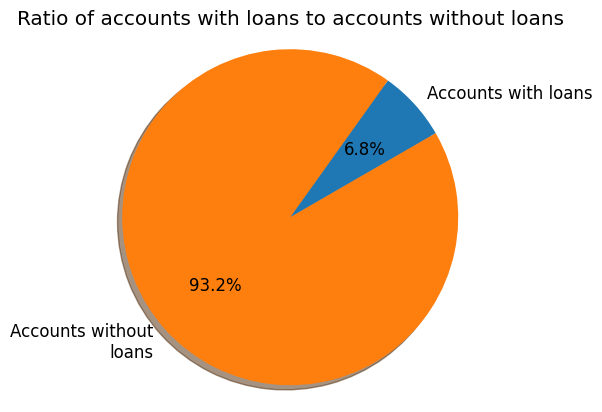

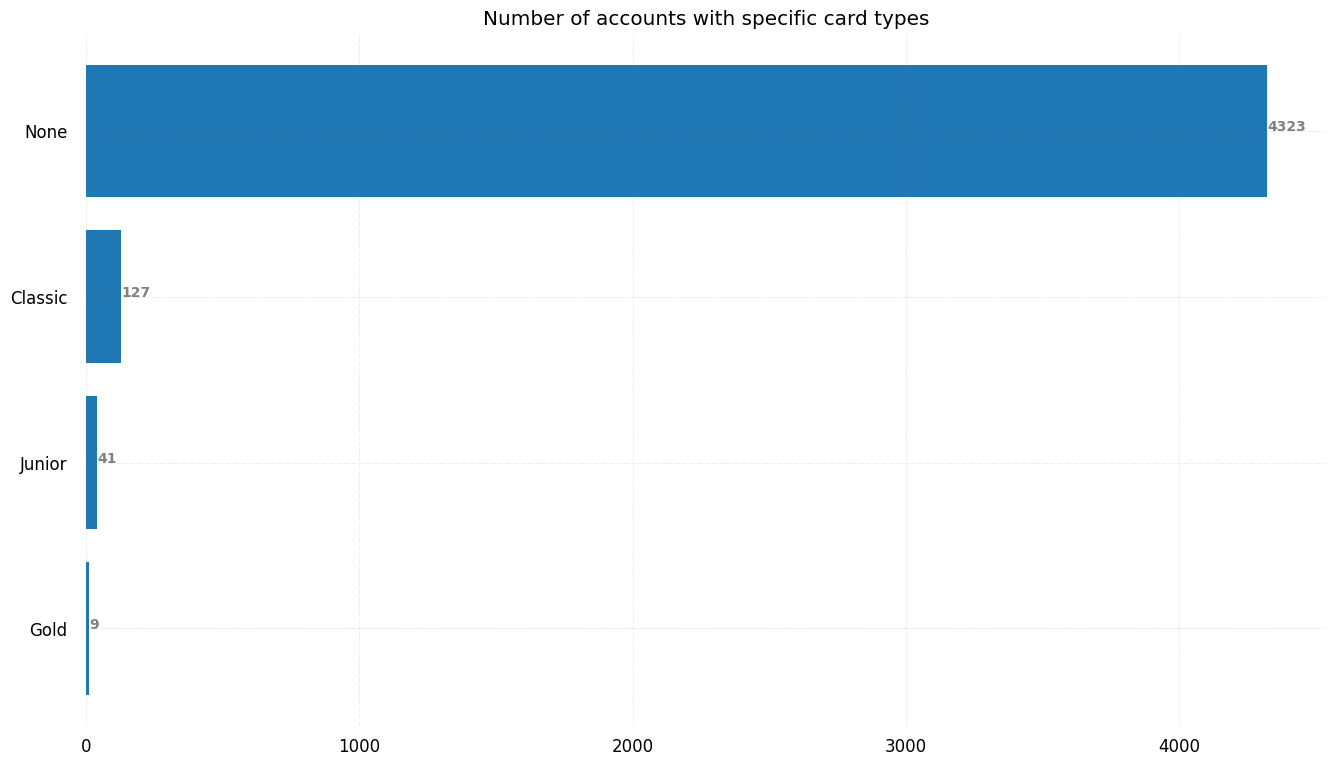

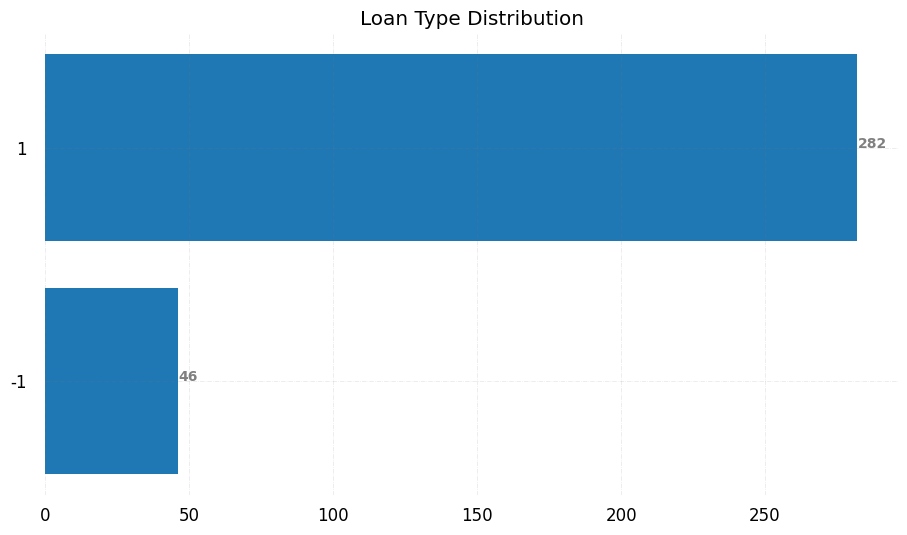

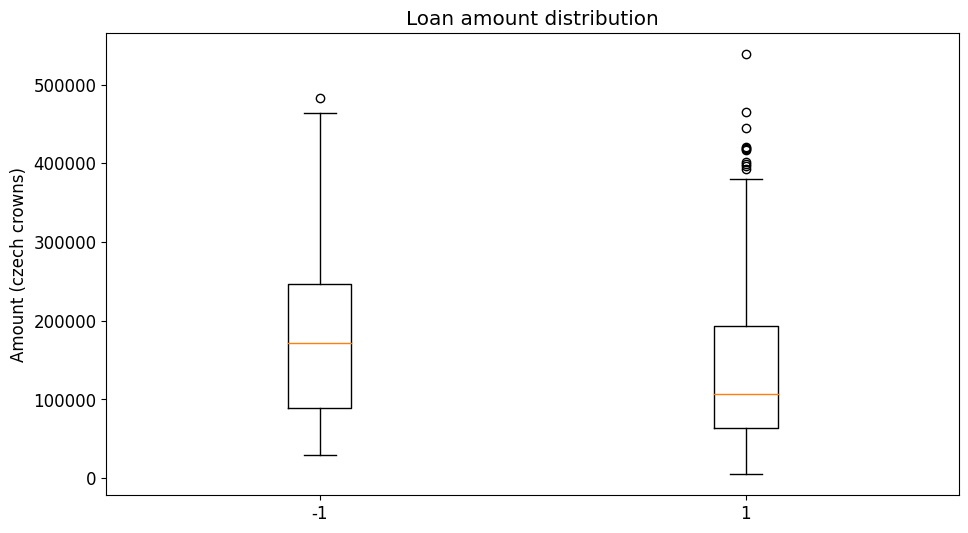

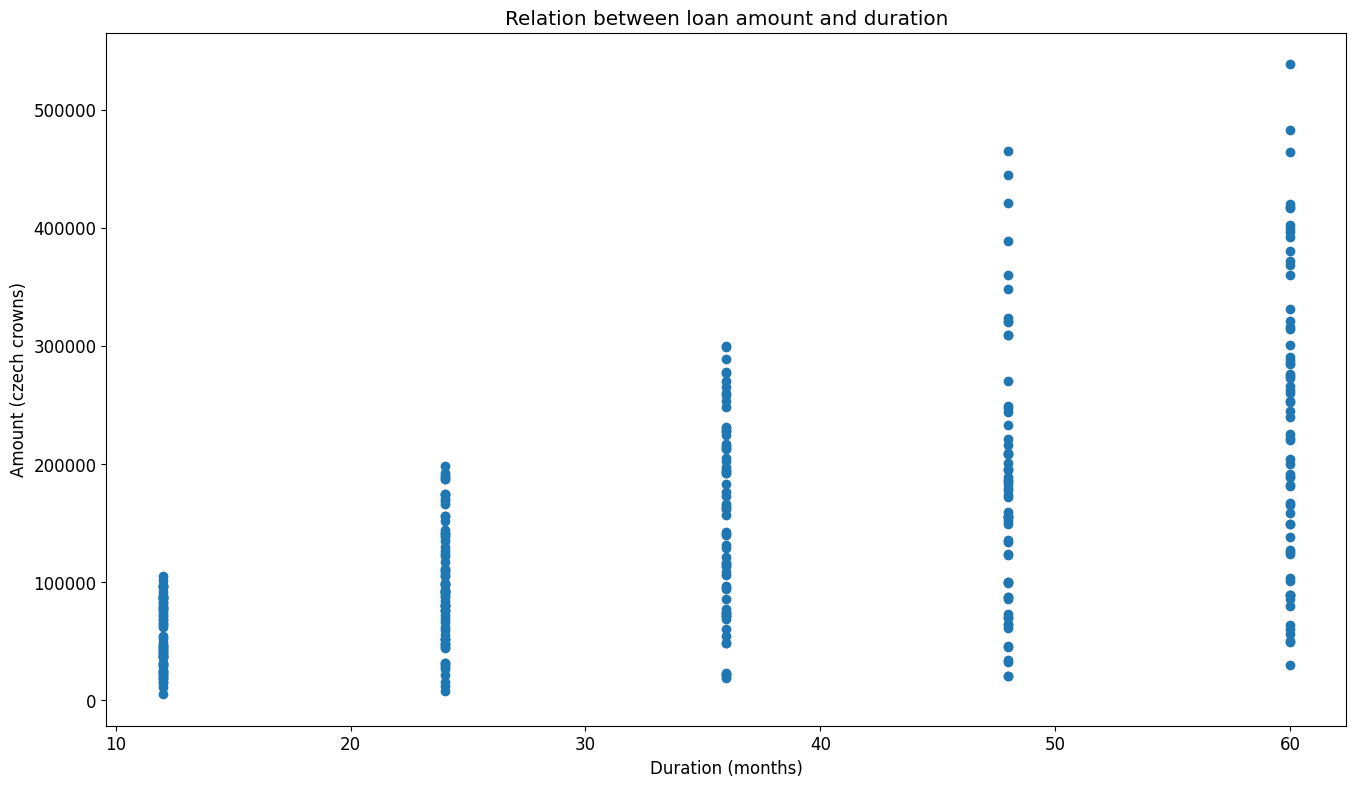

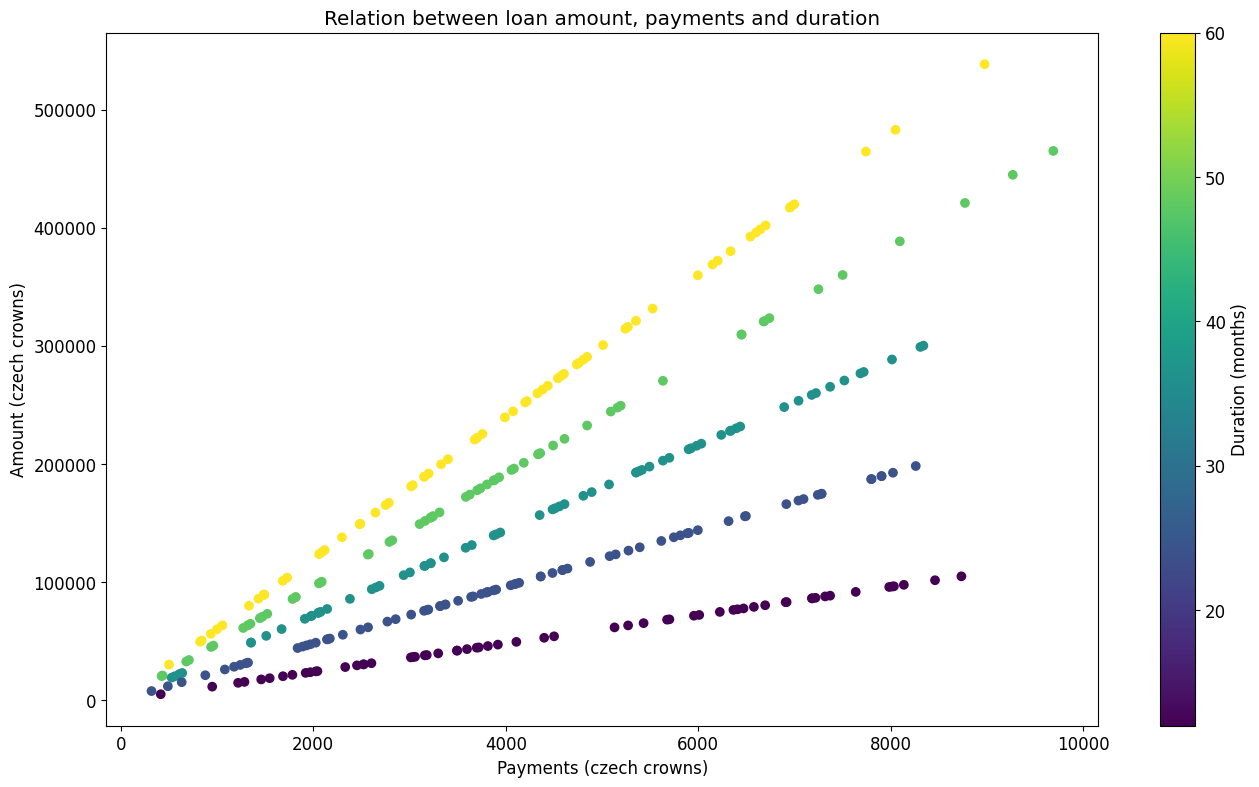

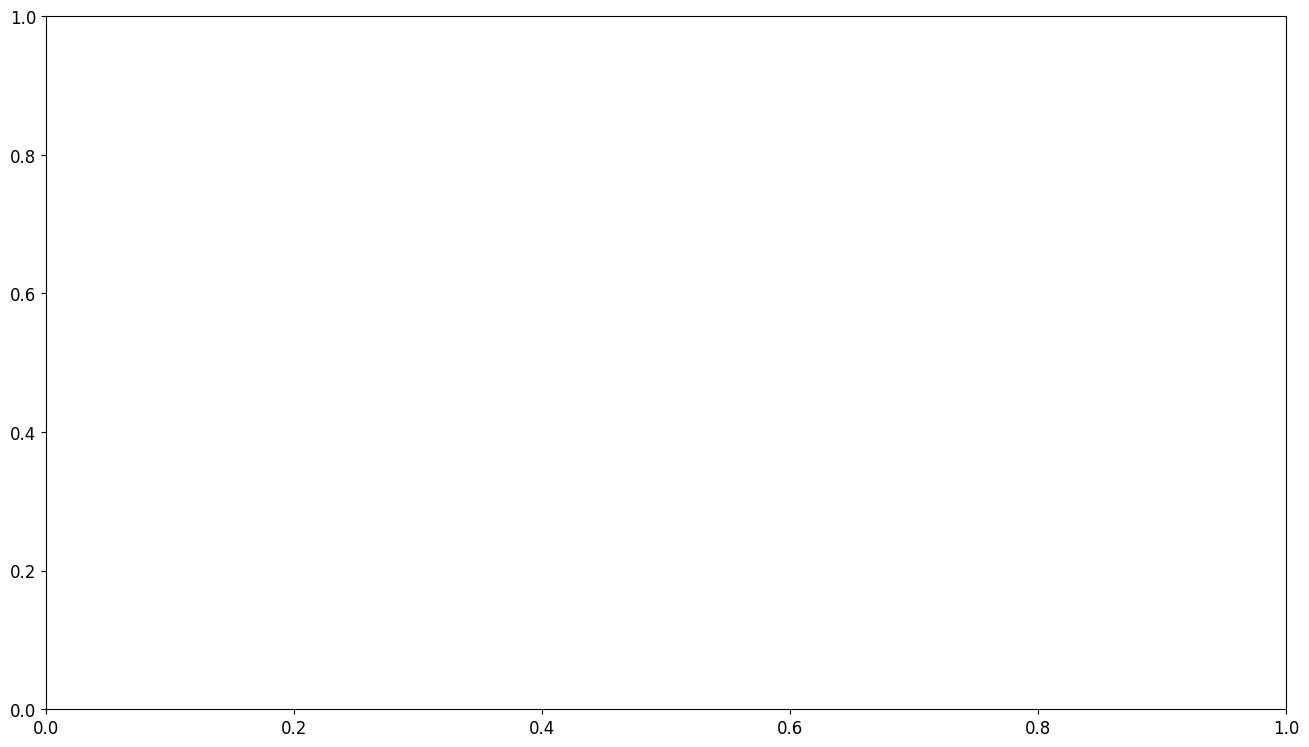

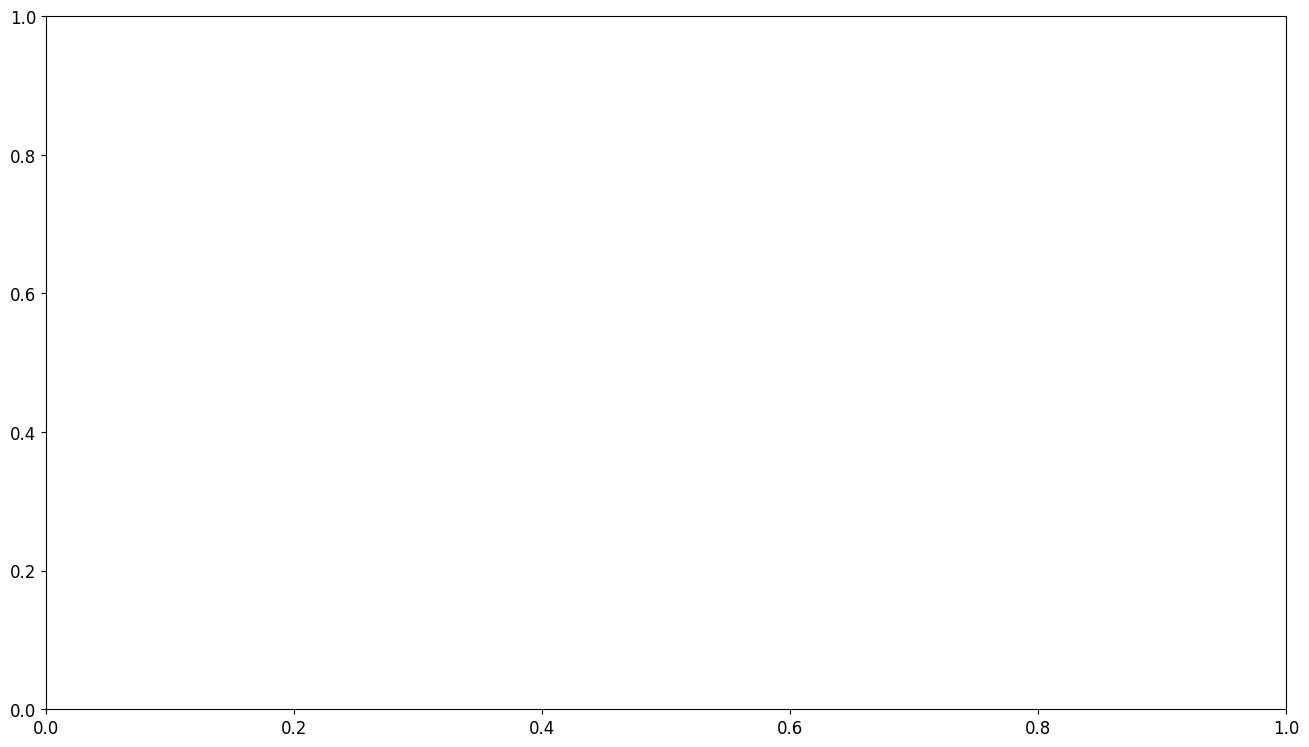

In [ ]:
plt.rcParams.update({'font.size': 12})
accounts_plot()
card_plot()
plot_loans()
plot_transactions()
plot_districts()
plot_final_dataset()